# Feature Engineering
## Echelon — Role-Aware Privileged Access Governance System

---

> **This notebook is the HEART of the Echelon project.**  
> We transform raw access logs into behavioral intelligence — 12 engineered features  
> that capture WHO is accessing WHAT, WHEN, and WHETHER their privileges are justified.

---

### What This Notebook Does

| Phase | What Happens | Output |
|-------|-------------|--------|
| **Section 1** | Load cleaned data & extract temporal components | Ready DataFrame |
| **Section 2** | Build 4 Behavioral Features | `avg_daily_access`, `export_ratio`, `unique_resources`, `avg_session_duration` |
| **Section 3** | Build 3 Temporal Features | `night_access_pct`, `weekend_activity_ratio`, `access_time_variance` |
| **Section 4** | Build 2 Stability/Drift Features | `weekly_access_change`, `access_spike_score` |
| **Section 5** | Build 3 Privilege-Usage Intelligence Features  | `privilege_usage_gap`, `privilege_usage_ratio`, `resource_access_concentration` |
| **Section 6** | Role-Based Z-Score Normalization | 12 z-score columns |
| **Section 7** | Governance Risk Score (0–100) | `governance_risk_score`, `risk_category` |
| **Section 8** | Validation & Save | `feature_engineered.csv` |

### Core Differentiator
Traditional systems ask: **"Did the user access the system?"** (yes/no)  
This system asks: **"Should the user even have access to that system?"** (intelligence)

### Input
`data/processed/cleaned_access_logs.csv`

### Output
`data/processed/feature_engineered.csv`

---
## Section 1: Setup, Imports & Data Loading
### 1.1 Import Libraries

In [91]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 1.1 — Imports
# ─────────────────────────────────────────────────────────────────────
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

# ── Add project root to path so src modules are importable ──
PROJECT_ROOT = Path('..').resolve()
sys.path.insert(0, str(PROJECT_ROOT))

# ── Plot Styling ──
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.dpi'        : 130,
    'axes.titlesize'    : 13,
    'axes.labelsize'    : 11,
    'xtick.labelsize'   : 9,
    'ytick.labelsize'   : 9,
    'axes.spines.top'   : False,
    'axes.spines.right' : False,
    'font.family'       : 'DejaVu Sans',
})

# ── Color Palette ──
ROLE_COLORS  = ['#3B82F6','#10B981','#F59E0B','#EF4444','#8B5CF6']
RISK_COLORS  = {'Low': '#16A34A', 'Medium': '#D97706', 'High': '#DC2626'}
FEAT_COLOR   = '#2563EB'
ACCENT       = '#7C3AED'

# ── Output Directories ──
FIG_DIR = PROJECT_ROOT / 'outputs' / 'figures' / 'feature_engineering'
FIG_DIR.mkdir(parents=True, exist_ok=True)

print('✓ Libraries loaded successfully')
print(f'✓ Project root : {PROJECT_ROOT}')
print(f'✓ Figures dir  : {FIG_DIR}')

✓ Libraries loaded successfully
✓ Project root : C:\Users\varsha\Documents\Projects\Echelon
✓ Figures dir  : C:\Users\varsha\Documents\Projects\Echelon\outputs\figures\feature_engineering


### 1.2 Load Cleaned Data

In [92]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 1.2 — Load Cleaned Data
# ─────────────────────────────────────────────────────────────────────
CLEAN_PATH = PROJECT_ROOT / 'data' / 'processed' / 'cleaned_access_logs.csv'

df = pd.read_csv(CLEAN_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print('═'*60)
print('  ECHELON — Feature Engineering Input')
print('═'*60)
print(f'  Records     : {len(df):,}')
print(f'  Columns     : {len(df.columns)}')
print(f'  Users       : {df["user_id"].nunique()}')
print(f'  Roles       : {df["role"].nunique()}')
print(f'  Date range  : {df["timestamp"].min().date()} → {df["timestamp"].max().date()}')
print(f'  Missing     : {df.isnull().sum().sum()}')
print('═'*60)

df.head(3)

════════════════════════════════════════════════════════════
  ECHELON — Feature Engineering Input
════════════════════════════════════════════════════════════
  Records     : 12,665
  Columns     : 10
  Users       : 100
  Roles       : 5
  Date range  : 2024-01-01 → 2024-12-30
  Missing     : 0
════════════════════════════════════════════════════════════


,user_id,role,resource_type,action,timestamp,session_duration,access_volume,success_flag,assigned_resource_count,actively_used_resource_count
0,USER_045,Cloud_Admin,gcp_console,read,2024-01-01 00:35:20,42.0,17.0,True,9,8
1,USER_055,Cloud_Admin,iam_console,write,2024-01-01 00:57:24,57.0,14.0,True,7,5
2,USER_064,Security_Admin,firewall_portal,write,2024-01-01 01:32:34,61.0,20.0,True,7,5


### 1.3 Extract Temporal Components

In [93]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 1.3 — Extract Temporal Components
#
#  Why? The raw timestamp column contains rich temporal information
#  that drives several features. We extract each component once here
#  so all downstream feature functions can use them directly.
# ─────────────────────────────────────────────────────────────────────
df['hour']        = df['timestamp'].dt.hour          # 0-23  (used for night_access, time_variance)
df['day_of_week'] = df['timestamp'].dt.dayofweek     # 0=Mon, 6=Sun (used for weekend_ratio)
df['week']        = df['timestamp'].dt.isocalendar().week.astype(int)  # 1-52 (used for weekly_change)
df['month']       = df['timestamp'].dt.month         # 1-12  (used for temporal plots)
df['date']        = df['timestamp'].dt.date          # YYYY-MM-DD (used for daily aggregation)

print('✓ Temporal components extracted:')
for col in ['hour', 'day_of_week', 'week', 'month', 'date']:
    print(f'   {col:15s} : {df[col].nunique()} unique values  |  sample: {df[col].iloc[0]}')

✓ Temporal components extracted:
   hour            : 24 unique values  |  sample: 0
   day_of_week     : 7 unique values  |  sample: 0
   week            : 52 unique values  |  sample: 1
   month           : 12 unique values  |  sample: 1
   date            : 365 unique values  |  sample: 2024-01-01


In [94]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 1.4 — Verify Privilege-Usage Columns Exist
#
#  These two columns were created by the data generator and are the
#  foundation of the Privilege-Usage Intelligence features (Section 5).
#  Without them, the core differentiator of this project cannot run.
# ─────────────────────────────────────────────────────────────────────
REQUIRED_PRIVILEGE_COLS = ['assigned_resource_count', 'actively_used_resource_count']

for col in REQUIRED_PRIVILEGE_COLS:
    if col not in df.columns:
        raise ValueError(f' Missing required column: {col}. Re-run data generator.')
    print(f'  ✓ {col} present  |  range: [{df[col].min()}, {df[col].max()}]  |  mean: {df[col].mean():.1f}')

print('\n✓ All privilege-usage columns verified. Ready to build features.')

  ✓ assigned_resource_count present  |  range: [5, 12]  |  mean: 8.5
  ✓ actively_used_resource_count present  |  range: [2, 11]  |  mean: 5.5

✓ All privilege-usage columns verified. Ready to build features.


---
## Section 2: Behavioral Features (4 Features)

> **What this section builds:** Core access behavior metrics that measure how much,  
> how broadly, and how long users access privileged systems.

| # | Feature | Measures | Risk Signal |
|---|---------|----------|-------------|
| 1 | `avg_daily_access` | Volume of daily access | High = possibly over-active |
| 2 | `export_ratio` | % of export actions | High = data exfiltration risk |
| 3 | `unique_resources` | Breadth of access | High = broad privilege scope |
| 4 | `avg_session_duration` | How long sessions last | Extremes = anomaly vs peers |

### 2.1 Feature 1 — Average Daily Access Volume

In [95]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 1: avg_daily_access
#
#  Definition : Mean number of resources accessed per calendar day
#  Formula    : mean(sum(access_volume per day)) per user
#  Risk Logic : High average → possible over-privileging or over-access
#               Must be compared WITHIN role (a Cloud_Admin naturally
#               accesses more than an HR_Admin).
# ─────────────────────────────────────────────────────────────────────
print('[Feature 1] Calculating avg_daily_access...')

# Step 1: Total access volume per user per day
daily_access = df.groupby(['user_id', 'date'])['access_volume'].sum().reset_index()

# Step 2: Average across all active days per user
avg_daily = daily_access.groupby('user_id')['access_volume'].mean()

# Step 3: Map back to main dataframe
df['avg_daily_access'] = df['user_id'].map(avg_daily)

print(f'  Range : [{df["avg_daily_access"].min():.2f}, {df["avg_daily_access"].max():.2f}]')
print(f'  Mean  : {df["avg_daily_access"].mean():.2f}   |   Std: {df["avg_daily_access"].std():.2f}')
print('  ✓ avg_daily_access created')

[Feature 1] Calculating avg_daily_access...
  Range : [8.52, 43.05]
  Mean  : 20.74   |   Std: 7.69
  ✓ avg_daily_access created


### 2.2 Feature 2 — Export Action Ratio

In [96]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 2: export_ratio
#
#  Definition : Percentage of a user's actions that are 'export'
#  Formula    : (count of export actions / total actions) × 100
#  Risk Logic : Normal users have 2–5% export ratio
#               Export-heavy users (15–28%) are governance red flags
#               because exports are the primary vector for data leakage
# ─────────────────────────────────────────────────────────────────────
print('[Feature 2] Calculating export_ratio...')

# Normalize action counts per user → gives proportions
user_actions = df.groupby('user_id')['action'].value_counts(normalize=True).unstack(fill_value=0)

# Extract export proportion (default 0 if user never exported)
export_pct = user_actions.get('export', pd.Series(0, index=user_actions.index)) * 100

df['export_ratio'] = df['user_id'].map(export_pct)

print(f'  Range : [{df["export_ratio"].min():.2f}%, {df["export_ratio"].max():.2f}%]')
print(f'  Mean  : {df["export_ratio"].mean():.2f}%   |   Std: {df["export_ratio"].std():.2f}%')
high_exporters = (df.groupby('user_id')['export_ratio'].first() > 15).sum()
print(f'  ⚠ Users with export_ratio > 15%: {high_exporters}')
print('  ✓ export_ratio created')

[Feature 2] Calculating export_ratio...
  Range : [0.00%, 27.50%]
  Mean  : 4.11%   |   Std: 4.58%
  ⚠ Users with export_ratio > 15%: 5
  ✓ export_ratio created


### 2.3 Feature 3 — Unique Resources Accessed

In [97]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 3: unique_resources
#
#  Definition : Count of distinct resource_type values accessed per user
#  Formula    : nunique(resource_type) per user
#  Risk Logic : Measures BREADTH of access
#               Principle of Least Privilege → narrow access is safer
#               Over-privileged users access many diverse resources
# ─────────────────────────────────────────────────────────────────────
print('[Feature 3] Calculating unique_resources...')

unique_res = df.groupby('user_id')['resource_type'].nunique()
df['unique_resources'] = df['user_id'].map(unique_res)

print(f'  Range : [{df["unique_resources"].min()}, {df["unique_resources"].max()}]')
print(f'  Mean  : {df["unique_resources"].mean():.2f}   |   Std: {df["unique_resources"].std():.2f}')
print('  ✓ unique_resources created')

[Feature 3] Calculating unique_resources...
  Range : [2, 11]
  Mean  : 5.46   |   Std: 2.21
  ✓ unique_resources created


### 2.4 Feature 4 — Average Session Duration

In [98]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 4: avg_session_duration
#
#  Definition : Mean session length (in minutes) per user
#  Formula    : mean(session_duration) per user
#  Risk Logic : This is highly role-dependent
#               DB_Admin: expected 60-90 min sessions
#               HR_Admin: expected 30-45 min sessions
#               Unusually short OR long sessions vs role peers = anomaly
# ─────────────────────────────────────────────────────────────────────
print('[Feature 4] Calculating avg_session_duration...')

avg_session = df.groupby('user_id')['session_duration'].mean()
df['avg_session_duration'] = df['user_id'].map(avg_session)

print(f'  Range : [{df["avg_session_duration"].min():.2f}, {df["avg_session_duration"].max():.2f}] minutes')
print(f'  Mean  : {df["avg_session_duration"].mean():.2f}   |   Std: {df["avg_session_duration"].std():.2f}')
print('  ✓ avg_session_duration created')

[Feature 4] Calculating avg_session_duration...
  Range : [32.05, 66.74] minutes
  Mean  : 48.74   |   Std: 10.90
  ✓ avg_session_duration created


### 2.5 Visualize All Behavioral Features by Role

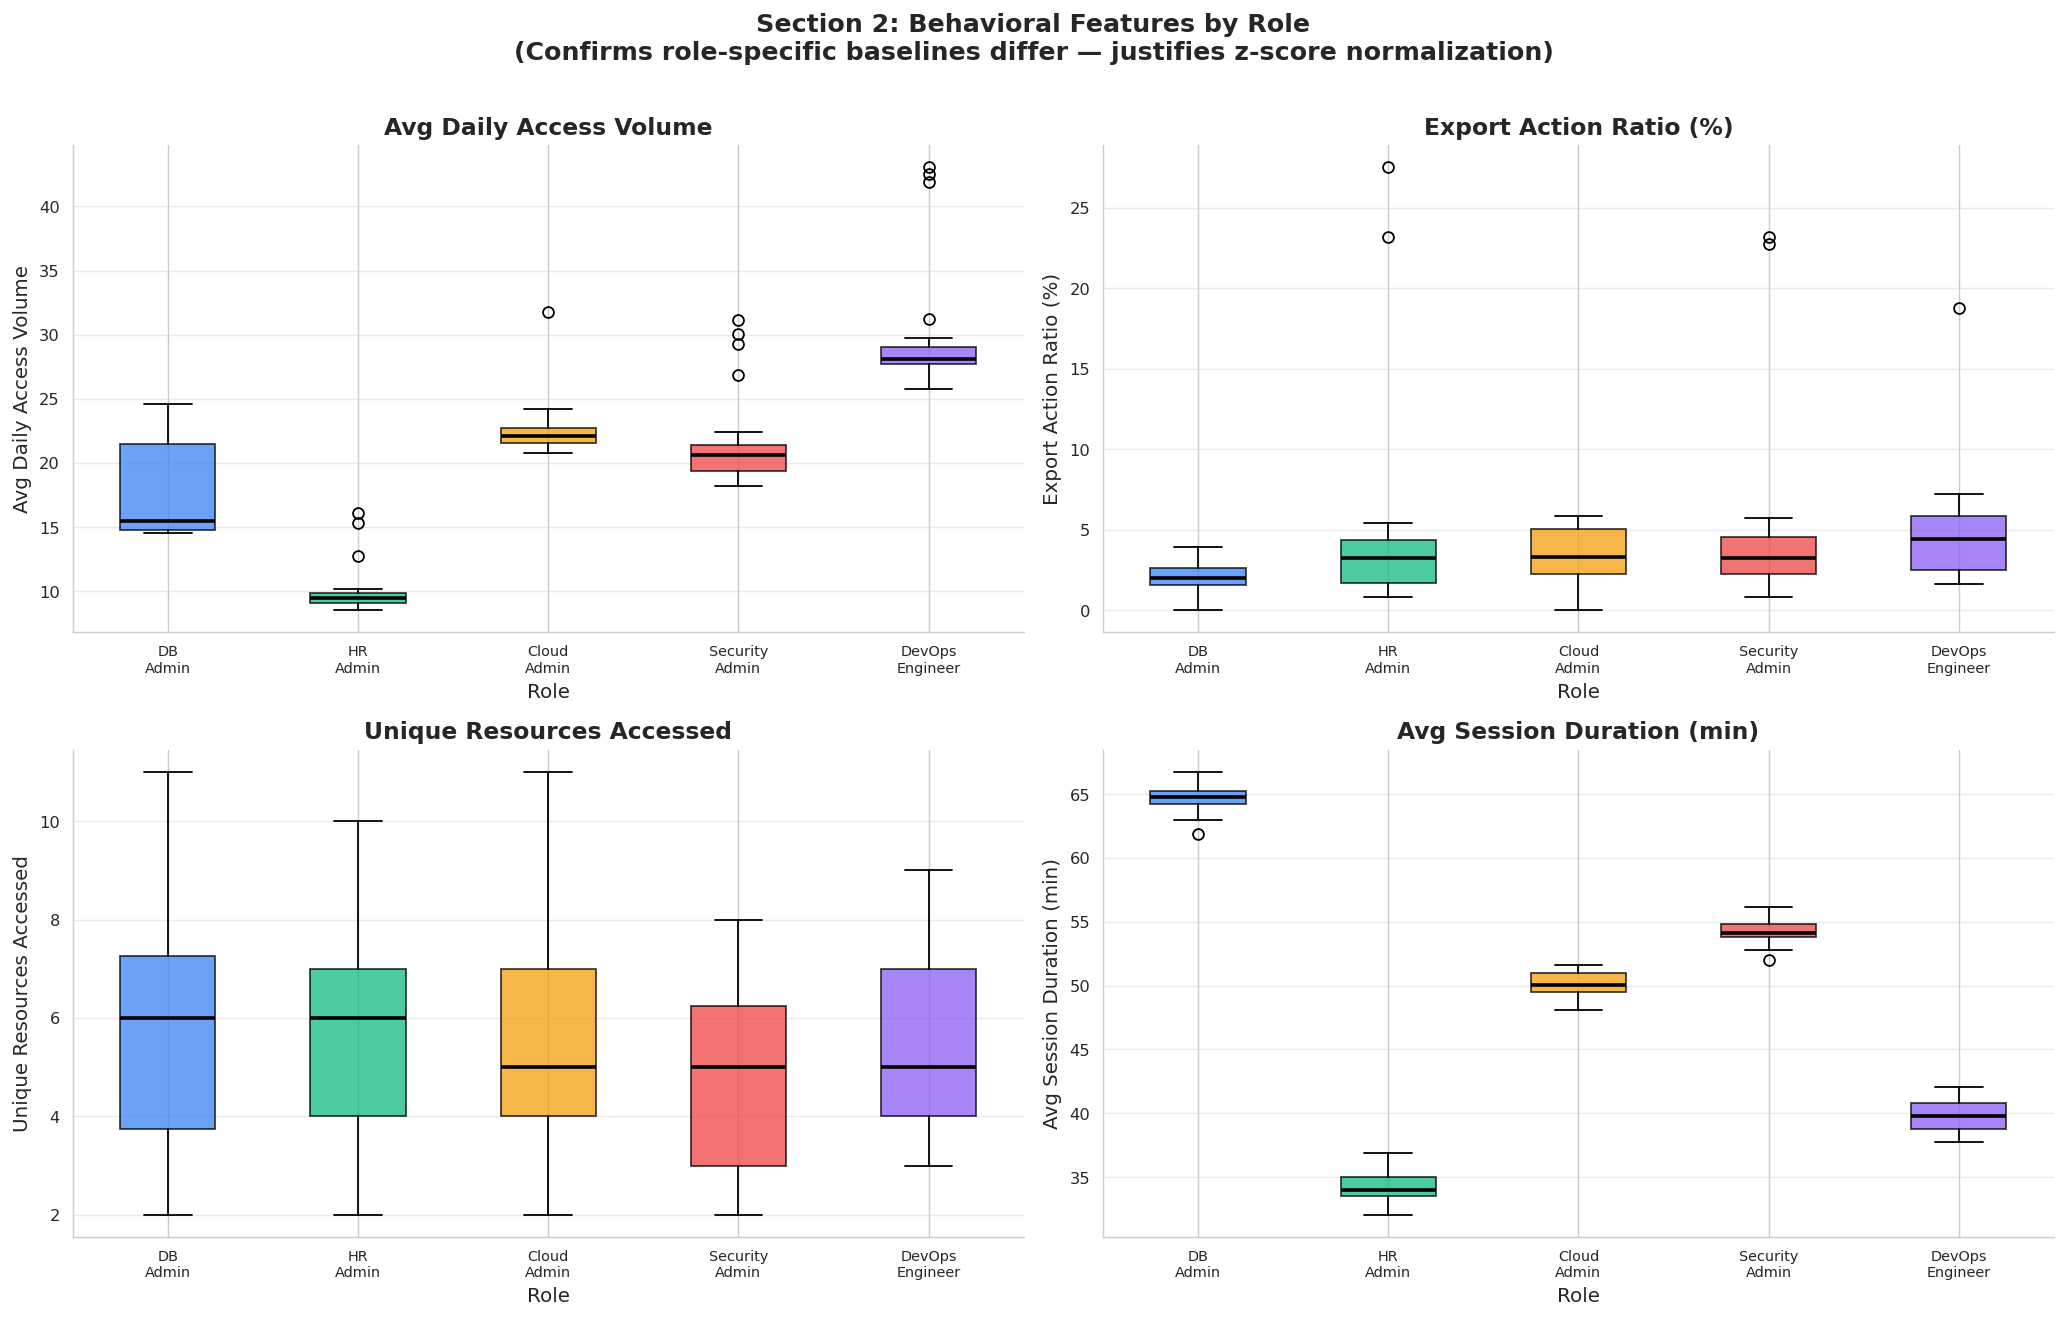

✓ Figure saved: feat_behavioral_by_role.png


In [99]:
# ─────────────────────────────────────────────────────────────────────
#  VISUALIZATION — Behavioral Features by Role
#
#  Why visualize now? Before computing z-scores, we must confirm that
#  role-specific baselines DIFFER. If all roles had the same distribution,
#  role-aware normalization would be unnecessary. These boxplots prove
#  that normalization is essential.
# ─────────────────────────────────────────────────────────────────────
user_level = df.groupby(['user_id', 'role']).agg(
    avg_daily_access    = ('avg_daily_access', 'first'),
    export_ratio        = ('export_ratio', 'first'),
    unique_resources    = ('unique_resources', 'first'),
    avg_session_duration= ('avg_session_duration', 'first'),
).reset_index()

ROLES = ['DB_Admin', 'HR_Admin', 'Cloud_Admin', 'Security_Admin', 'DevOps_Engineer']
user_level['role'] = pd.Categorical(user_level['role'], categories=ROLES, ordered=True)
user_level = user_level.sort_values('role')

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Section 2: Behavioral Features by Role\n'
             '(Confirms role-specific baselines differ — justifies z-score normalization)',
             fontsize=14, fontweight='bold', y=1.01)

plot_specs = [
    ('avg_daily_access',     'Avg Daily Access Volume',    axes[0,0]),
    ('export_ratio',         'Export Action Ratio (%)',    axes[0,1]),
    ('unique_resources',     'Unique Resources Accessed',  axes[1,0]),
    ('avg_session_duration', 'Avg Session Duration (min)', axes[1,1]),
]

for feat, label, ax in plot_specs:
    for i, role in enumerate(ROLES):
        subset = user_level[user_level['role'] == role][feat]
        bp = ax.boxplot(subset, positions=[i+1], widths=0.5, patch_artist=True,
                        medianprops=dict(color='black', linewidth=2))
        bp['boxes'][0].set_facecolor(ROLE_COLORS[i])
        bp['boxes'][0].set_alpha(0.75)
    ax.set_xticks(range(1, len(ROLES)+1))
    ax.set_xticklabels([r.replace('_', '\n') for r in ROLES], fontsize=8)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('Role')
    ax.set_ylabel(label)
    ax.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feat_behavioral_by_role.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: feat_behavioral_by_role.png')

---
## Section 3: Temporal Features (3 Features)

> **What this section builds:** Time-based patterns that reveal whether users  
> access systems at unusual hours — a key governance signal.

| # | Feature | Measures | Risk Signal |
|---|---------|----------|-------------|
| 5 | `night_access_pct` | % access 10 PM–6 AM | High (non-on-call roles) = anomaly |
| 6 | `weekend_activity_ratio` | % access Sat/Sun | High (non-on-call roles) = unusual |
| 7 | `access_time_variance` | Variance of access hours | High = erratic/unpredictable schedule |

### 3.1 Feature 5 — Night Access Percentage

In [100]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 5: night_access_pct
#
#  Definition : % of access events occurring between 10 PM and 6 AM
#  Formula    : (count(hour >= 22 OR hour <= 6) / total) × 100
#  Risk Logic :
#    LEGITIMATE night access  → Security_Admin, Cloud_Admin (24/7 on-call)
#    ANOMALOUS  night access  → DB_Admin, HR_Admin (9-5 business roles)
#    This is WHY we use role-aware z-scores, not global thresholds.
# ─────────────────────────────────────────────────────────────────────
print('[Feature 5] Calculating night_access_pct...')

# Flag: 1 if access is at night, 0 otherwise
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

# Mean of the flag = proportion = percentage
night_pct = df.groupby('user_id')['is_night'].mean() * 100
df['night_access_pct'] = df['user_id'].map(night_pct)

print(f'  Range : [{df["night_access_pct"].min():.2f}%, {df["night_access_pct"].max():.2f}%]')
print(f'  Mean  : {df["night_access_pct"].mean():.2f}%   |   Std: {df["night_access_pct"].std():.2f}%')
print('  ✓ night_access_pct created')

[Feature 5] Calculating night_access_pct...
  Range : [4.88%, 55.65%]
  Mean  : 29.90%   |   Std: 16.18%
  ✓ night_access_pct created


### 3.2 Feature 6 — Weekend Activity Ratio

In [101]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 6: weekend_activity_ratio
#
#  Definition : % of access events on Saturday (5) or Sunday (6)
#  Formula    : (count(day_of_week >= 5) / total) × 100
#  Risk Logic :
#    LEGITIMATE weekend → DevOps_Engineer (deployments), Security_Admin
#    ANOMALOUS weekend  → HR_Admin (purely business-hours role)
# ─────────────────────────────────────────────────────────────────────
print('[Feature 6] Calculating weekend_activity_ratio...')

df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
weekend_ratio = df.groupby('user_id')['is_weekend'].mean() * 100
df['weekend_activity_ratio'] = df['user_id'].map(weekend_ratio)

print(f'  Range : [{df["weekend_activity_ratio"].min():.2f}%, {df["weekend_activity_ratio"].max():.2f}%]')
print(f'  Mean  : {df["weekend_activity_ratio"].mean():.2f}%   |   Std: {df["weekend_activity_ratio"].std():.2f}%')
print('  ✓ weekend_activity_ratio created')

[Feature 6] Calculating weekend_activity_ratio...
  Range : [0.00%, 49.61%]
  Mean  : 27.67%   |   Std: 14.60%
  ✓ weekend_activity_ratio created


### 3.3 Feature 7 — Access Time Variance

In [102]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 7: access_time_variance
#
#  Definition : Variance in the hour-of-day across all access events
#  Formula    : var(hour) per user
#  Risk Logic :
#    LOW variance   → Consistent schedule (e.g., always 9-5)
#    HIGH variance  → Erratic timing — could indicate automation,
#                     scripted access, or compromised credentials
#    Note: 24/7 roles legitimately have higher variance (Security_Admin)
# ─────────────────────────────────────────────────────────────────────
print('[Feature 7] Calculating access_time_variance...')

time_var = df.groupby('user_id')['hour'].var()
df['access_time_variance'] = df['user_id'].map(time_var)
df['access_time_variance'] = df['access_time_variance'].fillna(0)  # Single-event users → 0

print(f'  Range : [{df["access_time_variance"].min():.2f}, {df["access_time_variance"].max():.2f}]')
print(f'  Mean  : {df["access_time_variance"].mean():.2f}   |   Std: {df["access_time_variance"].std():.2f}')
print('  ✓ access_time_variance created')

[Feature 7] Calculating access_time_variance...
  Range : [12.83, 67.01]
  Mean  : 39.37   |   Std: 17.42
  ✓ access_time_variance created


### 3.4 Visualize Temporal Features

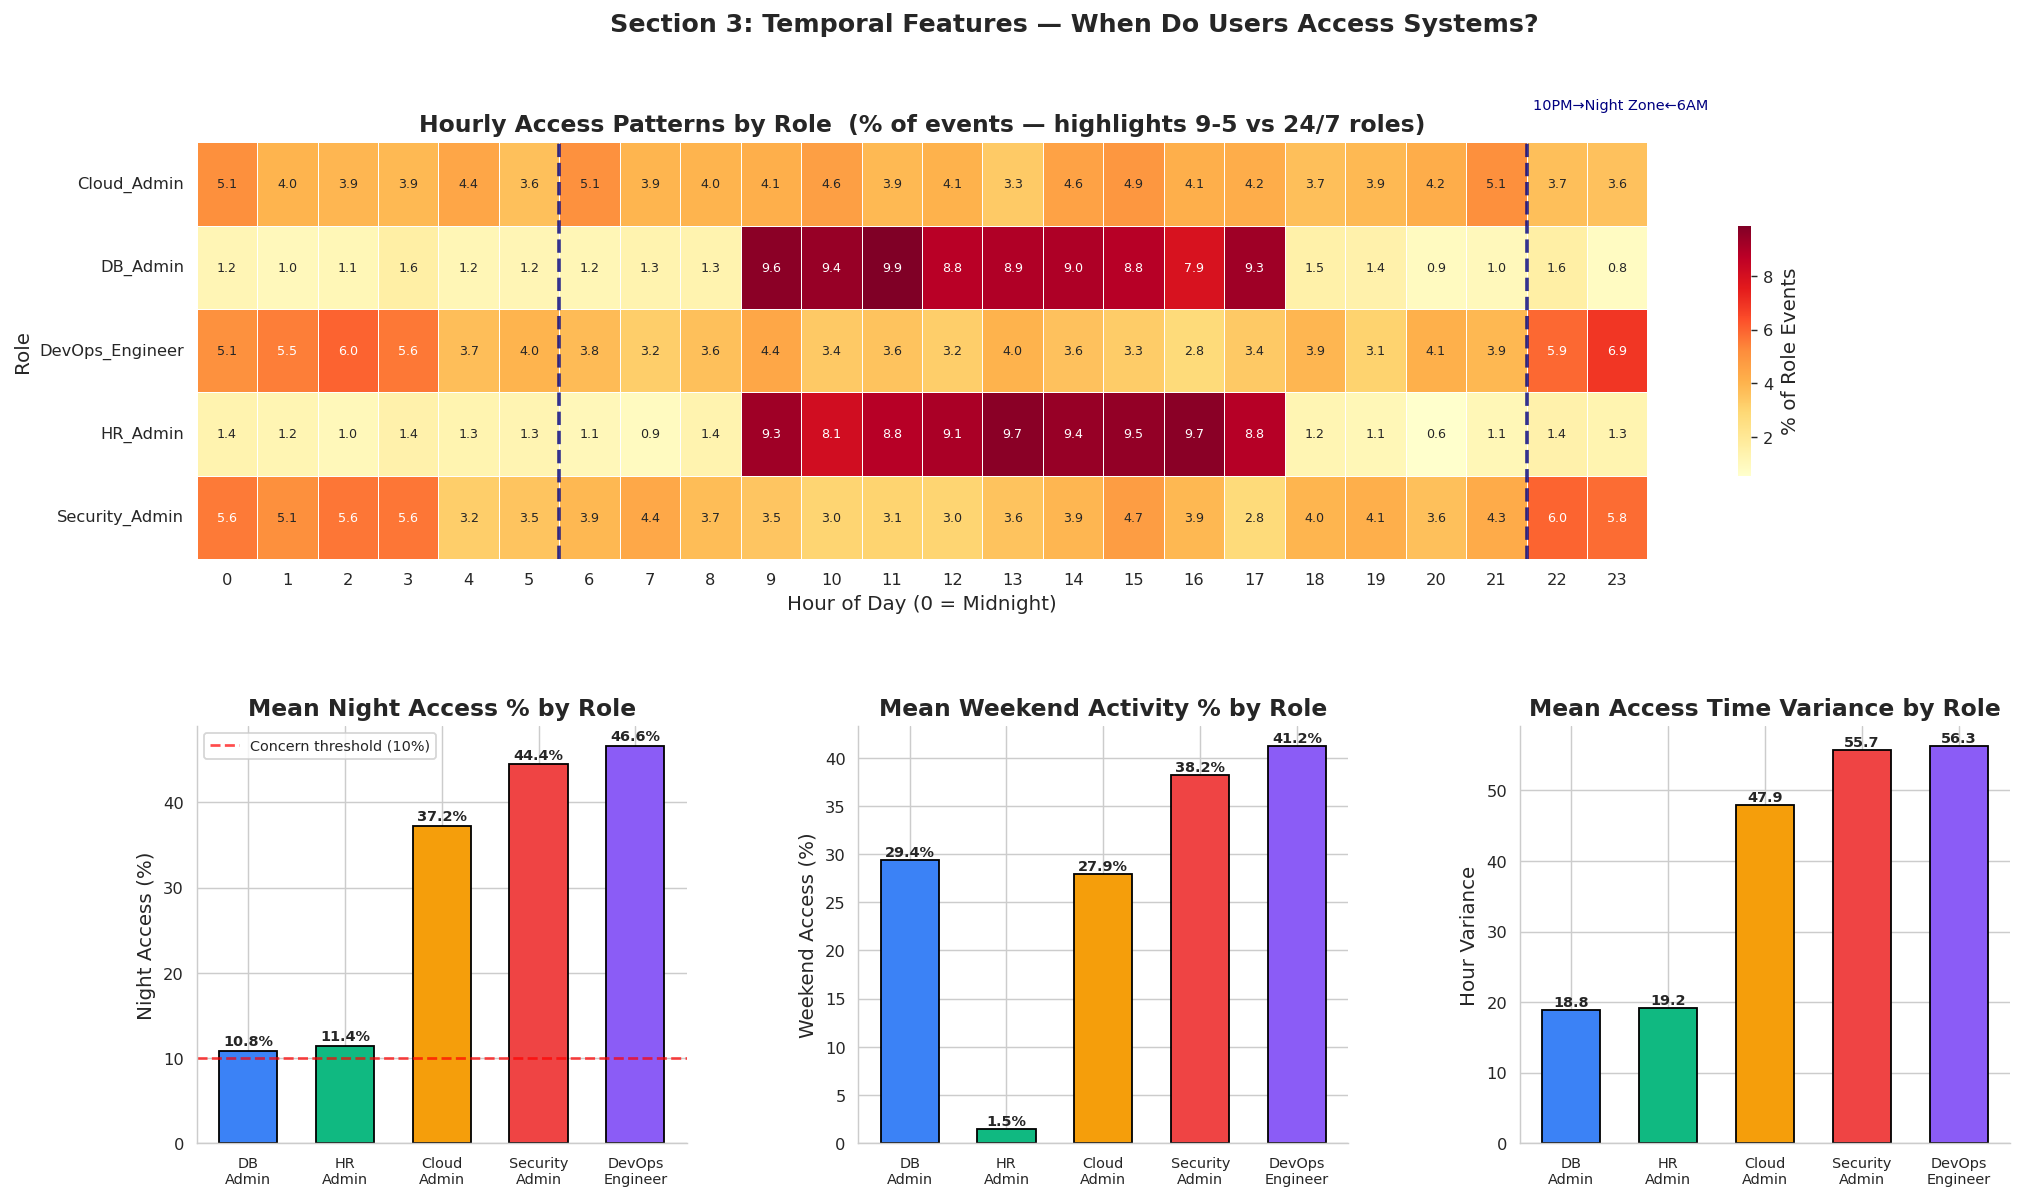

✓ Figure saved: feat_temporal_analysis.png


In [103]:
# ─────────────────────────────────────────────────────────────────────
#  VISUALIZATION — Temporal Features
#  Plot 1: Hourly activity heatmap by role (shows night/day patterns)
#  Plot 2: Night access % by role (proves role-specific baselines)
#  Plot 3: Weekend ratio by role
# ─────────────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Section 3: Temporal Features — When Do Users Access Systems?',
             fontsize=14, fontweight='bold')

gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# ── Panel 1: Hourly Heatmap ──
ax1 = fig.add_subplot(gs[0, :])
hour_role = df.groupby(['role', 'hour']).size().unstack(fill_value=0)
hour_role_norm = hour_role.div(hour_role.sum(axis=1), axis=0) * 100  # Normalize to %
sns.heatmap(hour_role_norm, cmap='YlOrRd', ax=ax1, linewidths=0.3,
            cbar_kws={'label': '% of Role Events', 'shrink': 0.6},
            annot=True, fmt='.1f', annot_kws={'size': 7})
ax1.set_title('Hourly Access Patterns by Role  (% of events — highlights 9-5 vs 24/7 roles)',
              fontweight='bold')
ax1.set_xlabel('Hour of Day (0 = Midnight)')
ax1.set_ylabel('Role')
ax1.axvline(x=22, color='navy', linewidth=2, linestyle='--', alpha=0.8)
ax1.axvline(x=6, color='navy', linewidth=2, linestyle='--', alpha=0.8)
ax1.text(22.1, -0.4, '10PM→Night Zone←6AM', fontsize=8, color='navy')

# ── Aggregate to user level for remaining panels ──
for col in ['night_access_pct', 'weekend_activity_ratio', 'access_time_variance']:
    user_level[col] = user_level['user_id'].map(
        df.groupby('user_id')[col].first())

# ── Panel 2: Night Access % ──
ax2 = fig.add_subplot(gs[1, 0])
role_night = user_level.groupby('role')['night_access_pct'].mean().reindex(ROLES)
bars = ax2.bar(range(len(ROLES)), role_night.values, color=ROLE_COLORS, edgecolor='black', width=0.6)
ax2.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Concern threshold (10%)')
ax2.set_xticks(range(len(ROLES)))
ax2.set_xticklabels([r.replace('_', '\n') for r in ROLES], fontsize=8)
ax2.set_title('Mean Night Access % by Role', fontweight='bold')
ax2.set_ylabel('Night Access (%)')
ax2.legend(fontsize=8)
for bar, val in zip(bars, role_night.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# ── Panel 3: Weekend Ratio ──
ax3 = fig.add_subplot(gs[1, 1])
role_wknd = user_level.groupby('role')['weekend_activity_ratio'].mean().reindex(ROLES)
bars3 = ax3.bar(range(len(ROLES)), role_wknd.values, color=ROLE_COLORS, edgecolor='black', width=0.6)
ax3.set_xticks(range(len(ROLES)))
ax3.set_xticklabels([r.replace('_', '\n') for r in ROLES], fontsize=8)
ax3.set_title('Mean Weekend Activity % by Role', fontweight='bold')
ax3.set_ylabel('Weekend Access (%)')
for bar, val in zip(bars3, role_wknd.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# ── Panel 4: Time Variance ──
ax4 = fig.add_subplot(gs[1, 2])
role_var = user_level.groupby('role')['access_time_variance'].mean().reindex(ROLES)
bars4 = ax4.bar(range(len(ROLES)), role_var.values, color=ROLE_COLORS, edgecolor='black', width=0.6)
ax4.set_xticks(range(len(ROLES)))
ax4.set_xticklabels([r.replace('_', '\n') for r in ROLES], fontsize=8)
ax4.set_title('Mean Access Time Variance by Role', fontweight='bold')
ax4.set_ylabel('Hour Variance')
for bar, val in zip(bars4, role_var.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.savefig(FIG_DIR / 'feat_temporal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: feat_temporal_analysis.png')

---
## Section 4: Stability & Drift Features (2 Features)

> **What this section builds:** Temporal consistency metrics that detect whether a user's  
> behavior is **drifting over time** or showing **sudden abnormal bursts**.

| # | Feature | Measures | Risk Signal |
|---|---------|----------|-------------|
| 8 | `weekly_access_change` | Std dev of week-over-week changes | High = volatile/drifting |
| 9 | `access_spike_score` | % events exceeding personal baseline +2σ | High = abnormal bursts |

### 4.1 Feature 8 — Weekly Access Change

In [104]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 8: weekly_access_change
#
#  Definition : Standard deviation of week-over-week access volume changes
#  Formula    : std(diff(weekly_total)) per user
#  Risk Logic :
#    Stable users    → Low week-to-week variation  (score ≈ 0)
#    Drifting users  → Consistently increasing trend
#    Volatile users  → Large random swings
#
#  This feature catches GRADUAL DRIFT which rule-based systems miss.
#  A user who slowly increases access by 5% per week won't trigger
#  any threshold alert, but their weekly_access_change score rises.
# ─────────────────────────────────────────────────────────────────────
print('[Feature 8] Calculating weekly_access_change...')

# Step 1: Sum access volume per user per ISO week
weekly_usage = df.groupby(['user_id', 'week'])['access_volume'].sum().reset_index()

# Step 2: Compute week-over-week DIFFERENCE (change, not total)
weekly_usage['weekly_diff'] = weekly_usage.groupby('user_id')['access_volume'].diff()

# Step 3: Std of those differences = instability score
weekly_instability = weekly_usage.groupby('user_id')['weekly_diff'].std().fillna(0)
df['weekly_access_change'] = df['user_id'].map(weekly_instability)

print(f'  Range : [{df["weekly_access_change"].min():.2f}, {df["weekly_access_change"].max():.2f}]')
print(f'  Mean  : {df["weekly_access_change"].mean():.2f}   |   Std: {df["weekly_access_change"].std():.2f}')
print('  ✓ weekly_access_change created')

[Feature 8] Calculating weekly_access_change...
  Range : [8.39, 60.00]
  Mean  : 21.04   |   Std: 8.83
  ✓ weekly_access_change created


### 4.2 Feature 9 — Access Spike Score

In [105]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 9: access_spike_score
#
#  Definition : % of events where access_volume exceeds user's own
#               personal baseline by more than 2 standard deviations
#  Formula    : (count(volume > mean + 2σ) / total events) × 100
#  Risk Logic :
#    Each user's PERSONAL baseline is used (not role average)
#    This personalizes the outlier detection — a normally high-volume
#    user will not be falsely flagged for expected behavior
#    Sudden spikes suggest: automation, data harvesting, or compromise
# ─────────────────────────────────────────────────────────────────────
print('[Feature 9] Calculating access_spike_score...')

# Step 1: Per-user baseline (mean + 2 std)
user_stats = df.groupby('user_id')['access_volume'].agg(['mean', 'std']).reset_index()
user_stats['spike_threshold'] = user_stats['mean'] + (2 * user_stats['std'])

# Step 2: Merge threshold into main df
df = df.merge(user_stats[['user_id', 'spike_threshold']], on='user_id', how='left')

# Step 3: Flag each event as spike or not
df['is_spike'] = (df['access_volume'] > df['spike_threshold']).astype(int)

# Step 4: % of spike events per user
spike_ratio = df.groupby('user_id')['is_spike'].mean() * 100
df['access_spike_score'] = df['user_id'].map(spike_ratio)

# Cleanup temp columns
df.drop(columns=['spike_threshold', 'is_spike'], inplace=True)

print(f'  Range : [{df["access_spike_score"].min():.2f}%, {df["access_spike_score"].max():.2f}%]')
print(f'  Mean  : {df["access_spike_score"].mean():.2f}%   |   Std: {df["access_spike_score"].std():.2f}%')
print('  ✓ access_spike_score created')

[Feature 9] Calculating access_spike_score...
  Range : [0.00%, 6.41%]
  Mean  : 2.57%   |   Std: 1.36%
  ✓ access_spike_score created


### 4.3 Visualize Stability Features — Drift Over Time

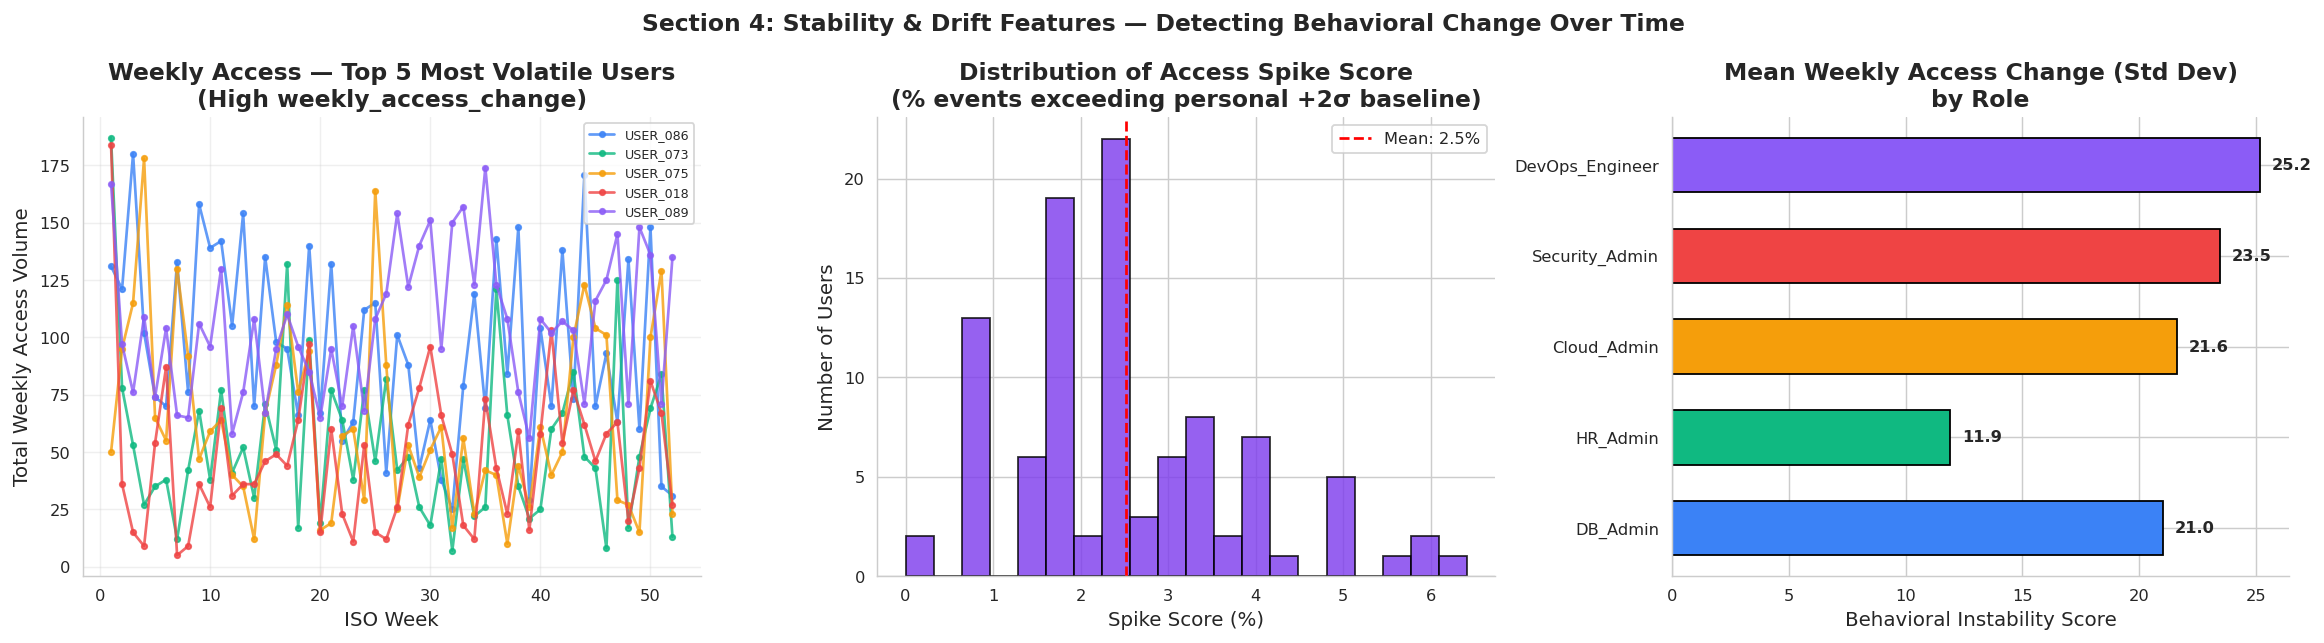

✓ Figure saved: feat_stability_drift.png


In [106]:
# ─────────────────────────────────────────────────────────────────────
#  VISUALIZATION — Behavioral Drift & Spike Analysis
#  Plot 1: Weekly access trends for top-5 most volatile users
#  Plot 2: Spike score distribution across roles
#  Plot 3: Weekly instability distribution
# ─────────────────────────────────────────────────────────────────────
# Update user_level with stability features
for col in ['weekly_access_change', 'access_spike_score']:
    user_level[col] = user_level['user_id'].map(df.groupby('user_id')[col].first())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Section 4: Stability & Drift Features — Detecting Behavioral Change Over Time',
             fontsize=13, fontweight='bold')

# ── Panel 1: Weekly Volume Trends (Top 5 Volatile Users) ──
ax = axes[0]
top5_volatile = user_level.nlargest(5, 'weekly_access_change')['user_id'].tolist()
weekly_agg = df[df['user_id'].isin(top5_volatile)].groupby(
    ['user_id', 'week'])['access_volume'].sum().reset_index()
for i, uid in enumerate(top5_volatile):
    sub = weekly_agg[weekly_agg['user_id'] == uid].sort_values('week')
    ax.plot(sub['week'], sub['access_volume'], marker='o', markersize=3,
            alpha=0.8, linewidth=1.5, label=uid, color=ROLE_COLORS[i % len(ROLE_COLORS)])
ax.set_title('Weekly Access — Top 5 Most Volatile Users\n(High weekly_access_change)', fontweight='bold')
ax.set_xlabel('ISO Week')
ax.set_ylabel('Total Weekly Access Volume')
ax.legend(fontsize=7)
ax.grid(alpha=0.3)

# ── Panel 2: Spike Score Distribution ──
ax2 = axes[1]
ax2.hist(user_level['access_spike_score'], bins=20, color=ACCENT, edgecolor='black', alpha=0.8)
ax2.axvline(user_level['access_spike_score'].mean(), color='red', linestyle='--',
            label=f'Mean: {user_level["access_spike_score"].mean():.1f}%')
ax2.set_title('Distribution of Access Spike Score\n(% events exceeding personal +2σ baseline)', fontweight='bold')
ax2.set_xlabel('Spike Score (%)')
ax2.set_ylabel('Number of Users')
ax2.legend(fontsize=9)

# ── Panel 3: Weekly Change by Role ──
ax3 = axes[2]
role_weekly = user_level.groupby('role')['weekly_access_change'].mean().reindex(ROLES)
bars = ax3.barh(range(len(ROLES)), role_weekly.values,
                color=ROLE_COLORS, edgecolor='black', height=0.6)
ax3.set_yticks(range(len(ROLES)))
ax3.set_yticklabels(ROLES, fontsize=9)
ax3.set_title('Mean Weekly Access Change (Std Dev)\nby Role', fontweight='bold')
ax3.set_xlabel('Behavioral Instability Score')
for bar, val in zip(bars, role_weekly.values):
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'feat_stability_drift.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: feat_stability_drift.png')

---
## Section 5: Privilege-Usage Intelligence Features (3 Features)

> ###  THIS IS THE CORE DIFFERENTIATOR OF THE ECHELON PROJECT
>
> **Traditional monitoring asks:** *"Did the user access the system?"*  
> **Echelon asks:** *"Should the user even HAVE access to that system?"*
>
> These 3 features measure the **gap between what users are ASSIGNED**  
> and **what they ACTUALLY USE** — a governance blind spot in every enterprise.

| # | Feature | Measures | Risk Signal |
|---|---------|----------|-------------|
| 10 | `privilege_usage_gap` | Assigned − Used (raw count) | High = over-provisioned |
| 11 | `privilege_usage_ratio` | % of assigned privileges used | Low (<50%) = governance risk |
| 12 | `resource_access_concentration` | CV of resource access frequency | High = ignoring most privileges |

### 5.1 Feature 10 — Privilege-Usage Gap

In [107]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 10: privilege_usage_gap  THE DEFINING FEATURE
#
#  Definition : Difference between assigned and actively used resource count
#  Formula    : assigned_resource_count − actively_used_resource_count
#  Risk Logic :
#    Gap = 0 → Perfect alignment. User uses everything they can access.
#    Gap = 3 → Moderate over-provisioning (3 unused privileges)
#    Gap ≥ 5 → Severe over-provisioning → GOVERNANCE RED FLAG
#
#  Example:
#    DB_Admin assigned 10 resources, uses only 3 → Gap = 7 (RISKY)
#    HR_Admin assigned 6 resources, uses 5       → Gap = 1 (HEALTHY)
# ─────────────────────────────────────────────────────────────────────
print('[Feature 10] Calculating privilege_usage_gap...')
print('   CORE FEATURE: Privilege-Usage Intelligence')

user_priv = df.groupby('user_id').agg(
    assigned = ('assigned_resource_count', 'first'),
    used     = ('actively_used_resource_count', 'first')
)

user_priv['privilege_usage_gap'] = user_priv['assigned'] - user_priv['used']
df['privilege_usage_gap'] = df['user_id'].map(user_priv['privilege_usage_gap'])

severely_over = (user_priv['privilege_usage_gap'] >= 5).sum()
print(f'  Gap Range   : [{df["privilege_usage_gap"].min():.0f}, {df["privilege_usage_gap"].max():.0f}] unused resources')
print(f'  Mean Gap    : {df["privilege_usage_gap"].mean():.2f} unused resources per user')
print(f'  ⚠ Severely over-provisioned (gap ≥ 5): {severely_over} users ({severely_over/user_priv.shape[0]*100:.1f}%)')
print('  ✓ privilege_usage_gap created')

[Feature 10] Calculating privilege_usage_gap...
   CORE FEATURE: Privilege-Usage Intelligence
  Gap Range   : [1, 9] unused resources
  Mean Gap    : 3.02 unused resources per user
  ⚠ Severely over-provisioned (gap ≥ 5): 16 users (16.0%)
  ✓ privilege_usage_gap created


### 5.2 Feature 11 — Privilege-Usage Ratio

In [108]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 11: privilege_usage_ratio
#
#  Definition : % of assigned privileges that are actively used
#  Formula    : (actively_used / assigned) × 100
#  Risk Logic :
#    90-100% → Well-aligned (uses almost everything assigned)
#    70-89%  → Acceptable (minor over-provisioning)
#    50-69%  → Concerning (significant over-provisioning)
#    < 50%   → GOVERNANCE RISK (uses less than half of what's granted)
# ─────────────────────────────────────────────────────────────────────
print('[Feature 11] Calculating privilege_usage_ratio...')

user_priv['privilege_usage_ratio'] = (
    user_priv['used'] / user_priv['assigned'].replace(0, 1)  # avoid div/0
) * 100

df['privilege_usage_ratio'] = df['user_id'].map(user_priv['privilege_usage_ratio'])

well_aligned   = (user_priv['privilege_usage_ratio'] >= 70).sum()
over_prov      = (user_priv['privilege_usage_ratio'] < 50).sum()

print(f'  Ratio Range       : [{df["privilege_usage_ratio"].min():.1f}%, {df["privilege_usage_ratio"].max():.1f}%]')
print(f'  Mean Ratio        : {df["privilege_usage_ratio"].mean():.1f}%')
print(f'  Well-aligned (≥70%): {well_aligned} users ({well_aligned/user_priv.shape[0]*100:.1f}%)')
print(f'  Over-provisioned  (<50%): {over_prov} users ({over_prov/user_priv.shape[0]*100:.1f}%)')
print('  ✓ privilege_usage_ratio created')

[Feature 11] Calculating privilege_usage_ratio...
  Ratio Range       : [18.2%, 91.7%]
  Mean Ratio        : 64.4%
  Well-aligned (≥70%): 48 users (48.0%)
  Over-provisioned  (<50%): 15 users (15.0%)
  ✓ privilege_usage_ratio created


### 5.3 Feature 12 — Resource Access Concentration

In [109]:
# ─────────────────────────────────────────────────────────────────────
#  FEATURE 12: resource_access_concentration
#
#  Definition : Coefficient of Variation (CV) of resource access frequency
#  Formula    : std(access_count per resource) / mean(access_count per resource)
#  Risk Logic :
#    LOW CV  (0.3-0.7) → User spreads access evenly across resources
#    HIGH CV (>1.5)    → User concentrates heavily on 1-2 resources
#                        and barely touches others (privilege hoarding)
#
#  WHY THIS MATTERS:
#    An over-provisioned user might access 8 resources but use
#    7 of them just 2-3 times while using the 8th hundreds of times.
#    This uneven access pattern signals the extra 7 privileges
#    serve no real purpose and should be revoked.
# ─────────────────────────────────────────────────────────────────────
print('[Feature 12] Calculating resource_access_concentration...')

# Access frequency: how many times each user accessed each resource
user_res_freq = df.groupby(['user_id', 'resource_type']).size().reset_index(name='access_count')

# CV = std / mean for each user (measures relative spread)
user_cv = user_res_freq.groupby('user_id')['access_count'].agg(
    lambda x: x.std() / x.mean() if x.mean() > 0 and len(x) > 1 else 0
)

df['resource_access_concentration'] = df['user_id'].map(user_cv)

print(f'  CV Range  : [{df["resource_access_concentration"].min():.2f}, {df["resource_access_concentration"].max():.2f}]')
print(f'  Mean CV   : {df["resource_access_concentration"].mean():.2f}')
print('  ✓ resource_access_concentration created')
print('\n All 12 features created successfully!')

[Feature 12] Calculating resource_access_concentration...
  CV Range  : [0.01, 0.86]
  Mean CV   : 0.22
  ✓ resource_access_concentration created

 All 12 features created successfully!


### 5.4 Visualize Privilege-Usage Intelligence

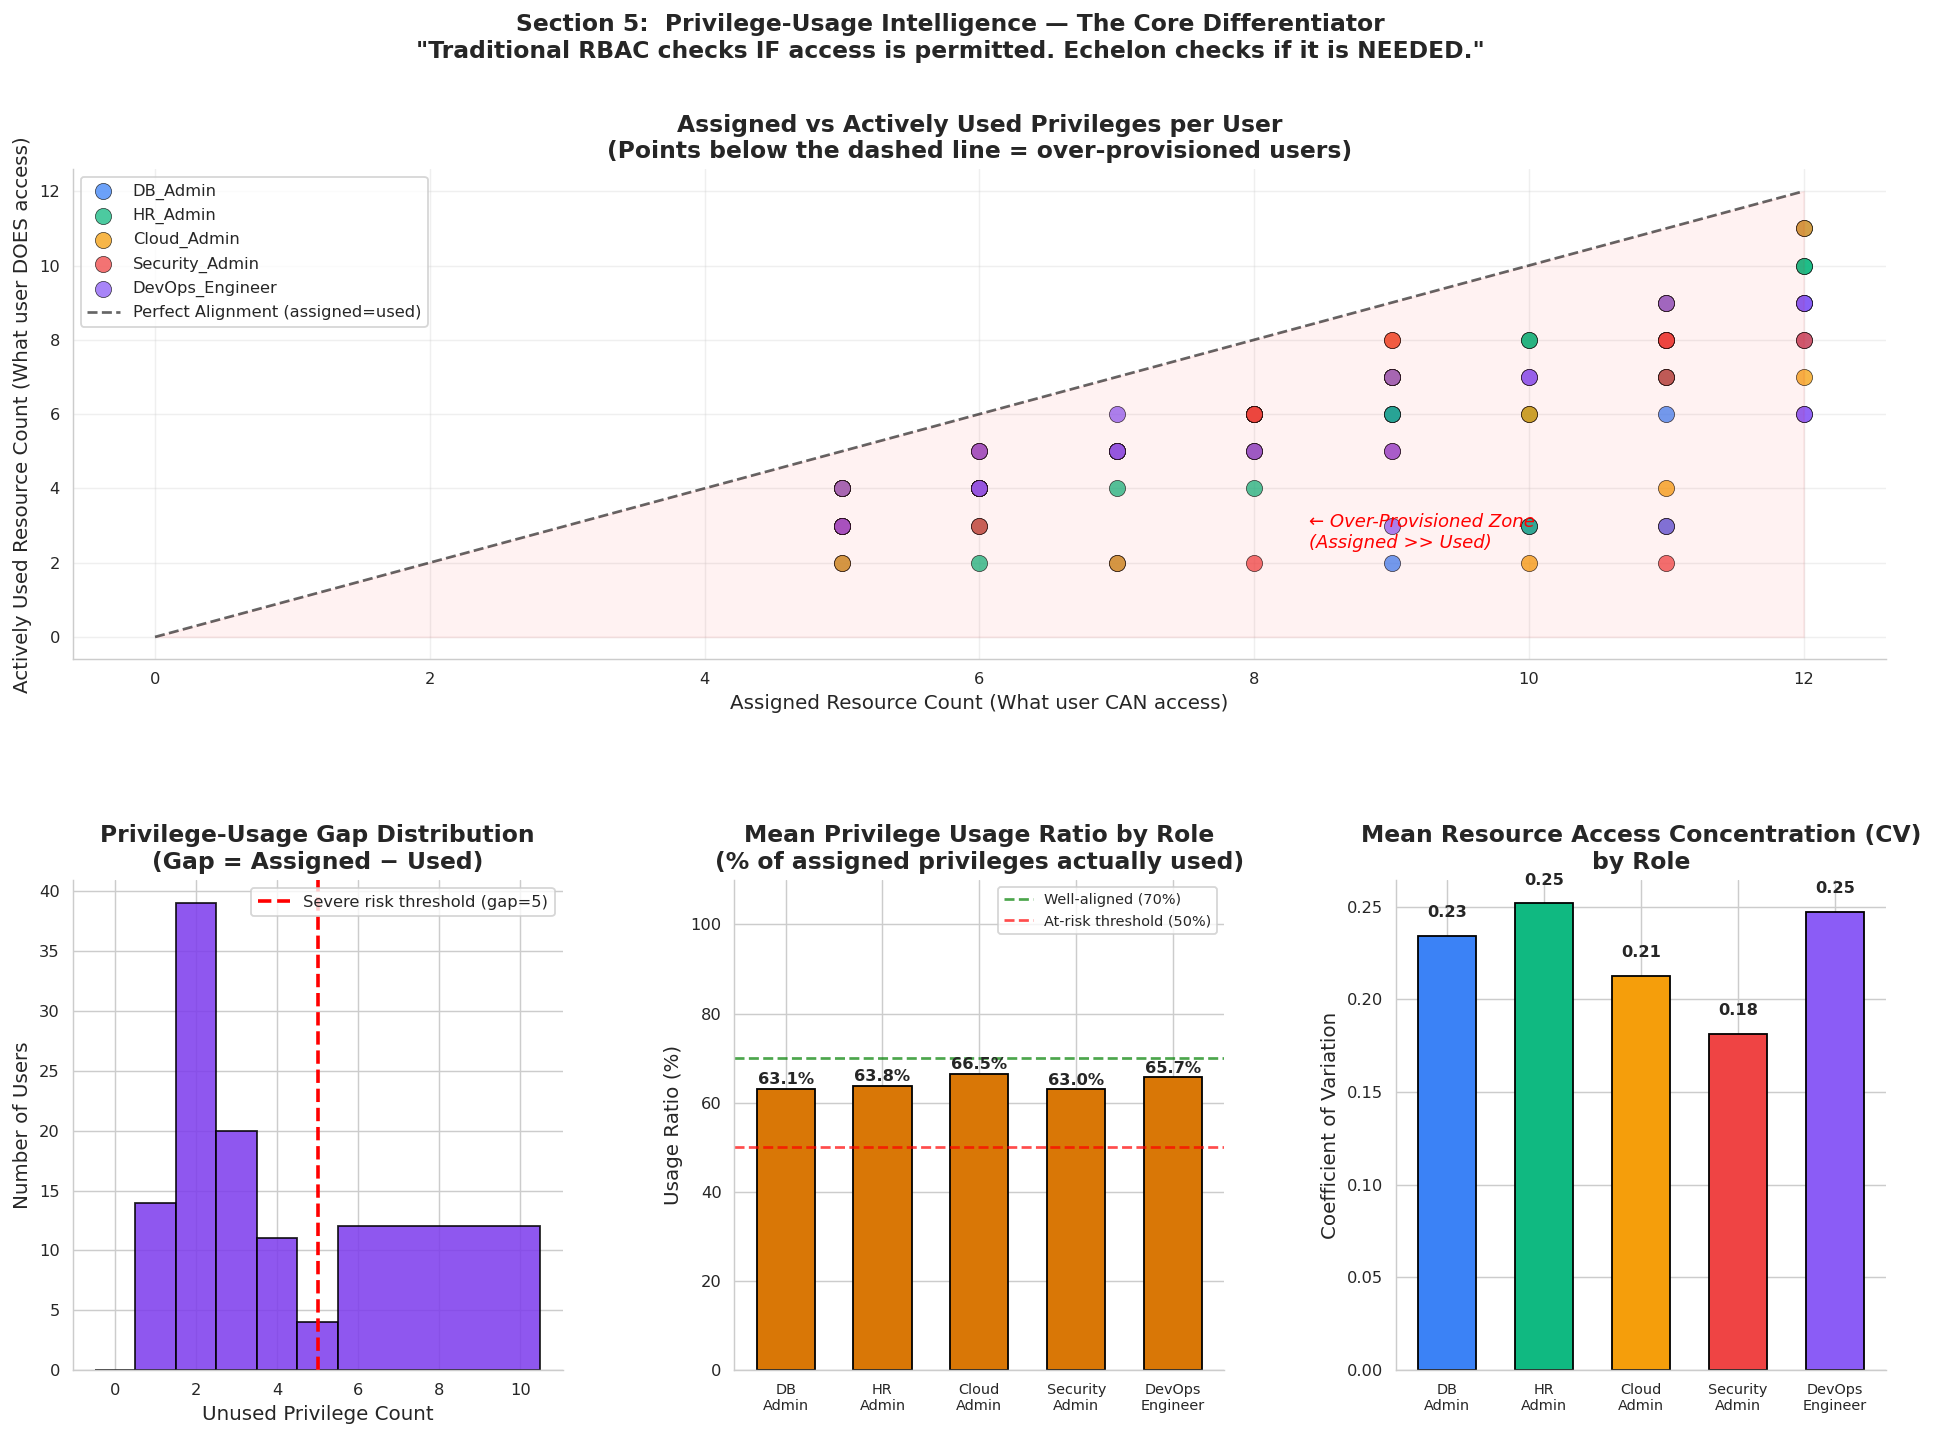

✓ Figure saved: feat_privilege_intelligence.png


In [110]:
# ─────────────────────────────────────────────────────────────────────
#  VISUALIZATION — Privilege-Usage Intelligence (The Core Story)
#  This visualization is the centerpiece of the project.
#  It shows CLEARLY which users have privileges they don't need.
# ─────────────────────────────────────────────────────────────────────
# Update user_level with privilege features
for col in ['privilege_usage_gap', 'privilege_usage_ratio', 'resource_access_concentration']:
    user_level[col] = user_level['user_id'].map(df.groupby('user_id')[col].first())

fig = plt.figure(figsize=(18, 12))
fig.suptitle('Section 5:  Privilege-Usage Intelligence — The Core Differentiator\n'
             '"Traditional RBAC checks IF access is permitted. Echelon checks if it is NEEDED."',
             fontsize=13, fontweight='bold')

gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.35)

# ── Panel 1: Assigned vs Used (Scatter) ──
ax1 = fig.add_subplot(gs[0, :])
scatter_data = user_level.copy()
assigned_vals = df.groupby('user_id')['assigned_resource_count'].first()
used_vals     = df.groupby('user_id')['actively_used_resource_count'].first()
scatter_data['assigned'] = scatter_data['user_id'].map(assigned_vals)
scatter_data['used']     = scatter_data['user_id'].map(used_vals)

for i, role in enumerate(ROLES):
    sub = scatter_data[scatter_data['role'] == role]
    ax1.scatter(sub['assigned'], sub['used'], s=80, color=ROLE_COLORS[i],
                label=role, alpha=0.75, edgecolors='black', linewidths=0.4)

# Perfect alignment line (assigned = used)
max_val = scatter_data['assigned'].max()
ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.6, linewidth=1.5, label='Perfect Alignment (assigned=used)')

# Shade the over-provisioned zone
ax1.fill_between([0, max_val], [0, max_val], 0, alpha=0.05, color='red')
ax1.text(max_val*0.7, max_val*0.2, '← Over-Provisioned Zone\n(Assigned >> Used)',
         color='red', fontsize=10, fontstyle='italic')

ax1.set_xlabel('Assigned Resource Count (What user CAN access)', fontsize=11)
ax1.set_ylabel('Actively Used Resource Count (What user DOES access)', fontsize=11)
ax1.set_title('Assigned vs Actively Used Privileges per User\n'
              '(Points below the dashed line = over-provisioned users)', fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(alpha=0.3)

# ── Panel 2: Privilege Gap Distribution ──
ax2 = fig.add_subplot(gs[1, 0])
gap_bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 10.5]
ax2.hist(user_level['privilege_usage_gap'], bins=gap_bins,
         color=ACCENT, edgecolor='black', alpha=0.85)
ax2.axvline(5, color='red', linestyle='--', linewidth=2, label='Severe risk threshold (gap=5)')
ax2.set_title('Privilege-Usage Gap Distribution\n(Gap = Assigned − Used)', fontweight='bold')
ax2.set_xlabel('Unused Privilege Count')
ax2.set_ylabel('Number of Users')
ax2.legend(fontsize=9)

# ── Panel 3: Usage Ratio by Role ──
ax3 = fig.add_subplot(gs[1, 1])
role_ratio = user_level.groupby('role')['privilege_usage_ratio'].mean().reindex(ROLES)
colors_ratio = ['#16A34A' if v >= 70 else '#D97706' if v >= 50 else '#DC2626'
                for v in role_ratio.values]
bars = ax3.bar(range(len(ROLES)), role_ratio.values, color=colors_ratio, edgecolor='black', width=0.6)
ax3.axhline(70, color='green', linestyle='--', alpha=0.7, linewidth=1.5, label='Well-aligned (70%)')
ax3.axhline(50, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='At-risk threshold (50%)')
ax3.set_xticks(range(len(ROLES)))
ax3.set_xticklabels([r.replace('_', '\n') for r in ROLES], fontsize=8)
ax3.set_title('Mean Privilege Usage Ratio by Role\n(% of assigned privileges actually used)', fontweight='bold')
ax3.set_ylabel('Usage Ratio (%)')
ax3.set_ylim(0, 110)
ax3.legend(fontsize=8)
for bar, val in zip(bars, role_ratio.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.1f}%', ha='center', fontsize=9, fontweight='bold')

# ── Panel 4: Concentration by Role ──
ax4 = fig.add_subplot(gs[1, 2])
role_conc = user_level.groupby('role')['resource_access_concentration'].mean().reindex(ROLES)
bars4 = ax4.bar(range(len(ROLES)), role_conc.values, color=ROLE_COLORS, edgecolor='black', width=0.6)
ax4.set_xticks(range(len(ROLES)))
ax4.set_xticklabels([r.replace('_', '\n') for r in ROLES], fontsize=8)
ax4.set_title('Mean Resource Access Concentration (CV)\nby Role', fontweight='bold')
ax4.set_ylabel('Coefficient of Variation')
for bar, val in zip(bars4, role_conc.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.savefig(FIG_DIR / 'feat_privilege_intelligence.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: feat_privilege_intelligence.png')

═════════════════════════════════════════════════════════════════
  TOP 15 MOST OVER-PROVISIONED USERS
  (Sorted by privilege_usage_gap — highest = most unused privileges)
═════════════════════════════════════════════════════════════════
 user_id            role  privilege_usage_gap  privilege_usage_ratio
USER_065  Security_Admin                    9              18.181818
USER_082 DevOps_Engineer                    8              27.272727
USER_048     Cloud_Admin                    8              20.000000
USER_021        HR_Admin                    8              27.272727
USER_026        HR_Admin                    7              30.000000
USER_058     Cloud_Admin                    7              36.363636
USER_020        DB_Admin                    7              22.222222
USER_005        DB_Admin                    7              30.000000
USER_074  Security_Admin                    6              25.000000
USER_091 DevOps_Engineer                    6              33.333333
USE

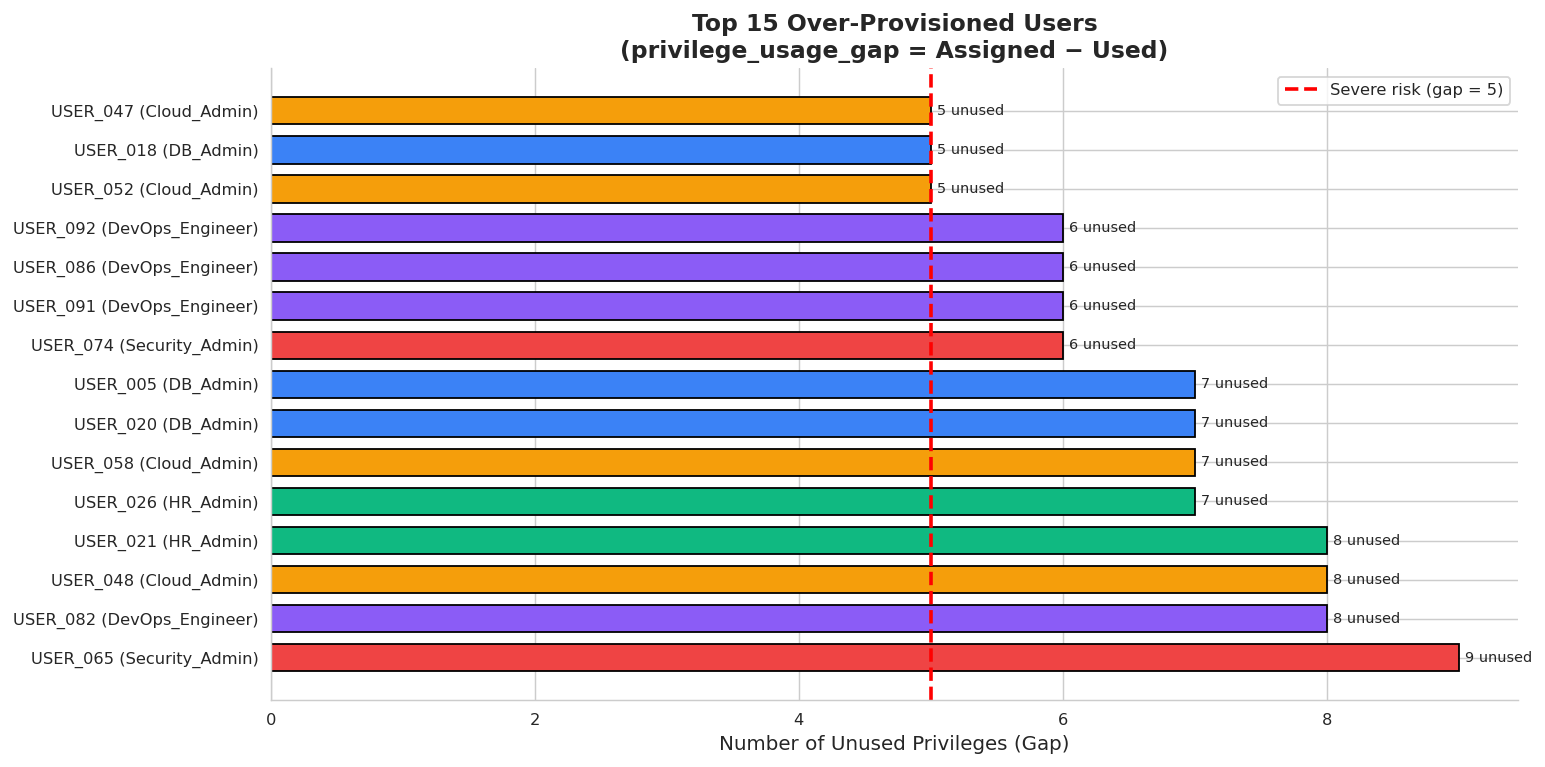

✓ Figure saved: privilege_gap_sorted.png


In [111]:
# ── Top Over-Provisioned Users: Sorted Gap Table ──
gap_table = user_level[['user_id', 'role', 'privilege_usage_gap', 'privilege_usage_ratio']].copy()
gap_table = gap_table.drop_duplicates().sort_values('privilege_usage_gap', ascending=False)

print('═'*65)
print('  TOP 15 MOST OVER-PROVISIONED USERS')
print('  (Sorted by privilege_usage_gap — highest = most unused privileges)')
print('═'*65)
print(gap_table.head(15).to_string(index=False))

# ── Save as sorted figure ──
fig, ax = plt.subplots(figsize=(12, 6))
top15 = gap_table.head(15)
bar_colors = [ROLE_COLORS[ROLES.index(r)] for r in top15['role']]
bars = ax.barh(range(len(top15)), top15['privilege_usage_gap'].values,
               color=bar_colors, edgecolor='black', height=0.7)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels([f"{row['user_id']} ({row['role']})" for _, row in top15.iterrows()], fontsize=9)
ax.set_xlabel('Number of Unused Privileges (Gap)', fontsize=11)
ax.set_title('Top 15 Over-Provisioned Users\n(privilege_usage_gap = Assigned − Used)', fontweight='bold', fontsize=13)
ax.axvline(5, color='red', linestyle='--', linewidth=2, label='Severe risk (gap = 5)')
ax.legend(fontsize=9)
for bar, val in zip(bars, top15['privilege_usage_gap'].values):
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            f'{val:.0f} unused', va='center', fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / 'privilege_gap_sorted.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: privilege_gap_sorted.png')

---
## Section 6: Role-Based Z-Score Normalization (12 Z-Scores)

> **This is what makes Echelon resume-heavy and technically rigorous.**
>
> **Problem with global comparisons:**  
> A Cloud_Admin accessing 25 resources/day is normal.  
> An HR_Admin accessing 25 resources/day is highly anomalous.  
> A global threshold would either miss the HR_Admin or falsely flag the Cloud_Admin.
>
> **Solution — Role-Aware Z-Scores:**  
> `z = (user_value - role_mean) / role_std`  
> Each user is compared ONLY to peers in the same role.

### 6.1 Calculate Role-Based Z-Scores for All 12 Features

In [112]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 6: Role-Based Z-Score Normalization
#
#  For each of the 12 features:
#    1. Group by role
#    2. Compute role-specific mean and std
#    3. z = (user_value - role_mean) / role_std
#    4. fillna(0) → handles edge case where all role members have same value
#
#  Interpretation:
#    z ≈ 0   → User is at role average (expected behavior)
#    z = +2  → 2 std above role peers (unusual, investigate)
#    z = +3  → Statistical outlier within role (high governance risk)
#    z = -2  → 2 std below role peers (also unusual)
# ─────────────────────────────────────────────────────────────────────
print('\n[SECTION 6] Calculating Role-Based Z-Scores for all 12 features...')
print('='*60)

FEATURES_TO_NORMALIZE = [
    # Behavioral (4)
    'avg_daily_access',
    'export_ratio',
    'unique_resources',
    'avg_session_duration',
    # Temporal (3)
    'night_access_pct',
    'weekend_activity_ratio',
    'access_time_variance',
    # Stability (2)
    'weekly_access_change',
    'access_spike_score',
    # Privilege Intelligence (3) 
    'privilege_usage_gap',
    'privilege_usage_ratio',
    'resource_access_concentration',
]

print(f'  Normalizing {len(FEATURES_TO_NORMALIZE)} features against role-specific peers...')

for feature in FEATURES_TO_NORMALIZE:
    # Role-specific statistics
    role_stats = df.groupby('role')[feature].agg(['mean', 'std']).reset_index()
    role_stats.columns = ['role', f'{feature}_rmean', f'{feature}_rstd']

    # Merge back
    df = df.merge(role_stats, on='role', how='left')

    # Z-score calculation
    df[f'{feature}_zscore'] = (
        (df[feature] - df[f'{feature}_rmean']) / df[f'{feature}_rstd']
    ).fillna(0)

    # Drop temp columns
    df.drop(columns=[f'{feature}_rmean', f'{feature}_rstd'], inplace=True)

    z_col = f'{feature}_zscore'
    print(f'  ✓ {z_col:42s} | mean={df[z_col].mean():.3f}  std={df[z_col].std():.3f}')

print(f'\n   All {len(FEATURES_TO_NORMALIZE)} z-scores calculated')


[SECTION 6] Calculating Role-Based Z-Scores for all 12 features...
  Normalizing 12 features against role-specific peers...
  ✓ avg_daily_access_zscore                    | mean=-0.000  std=1.000
  ✓ export_ratio_zscore                        | mean=0.000  std=1.000
  ✓ unique_resources_zscore                    | mean=-0.000  std=1.000
  ✓ avg_session_duration_zscore                | mean=-0.000  std=1.000
  ✓ night_access_pct_zscore                    | mean=0.000  std=1.000
  ✓ weekend_activity_ratio_zscore              | mean=-0.000  std=1.000
  ✓ access_time_variance_zscore                | mean=0.000  std=1.000
  ✓ weekly_access_change_zscore                | mean=0.000  std=1.000
  ✓ access_spike_score_zscore                  | mean=0.000  std=1.000
  ✓ privilege_usage_gap_zscore                 | mean=-0.000  std=1.000
  ✓ privilege_usage_ratio_zscore               | mean=0.000  std=1.000
  ✓ resource_access_concentration_zscore       | mean=-0.000  std=1.000

   All 12 z-scor

### 6.2 Visualize Z-Score Distributions — Proving Normalization Worked

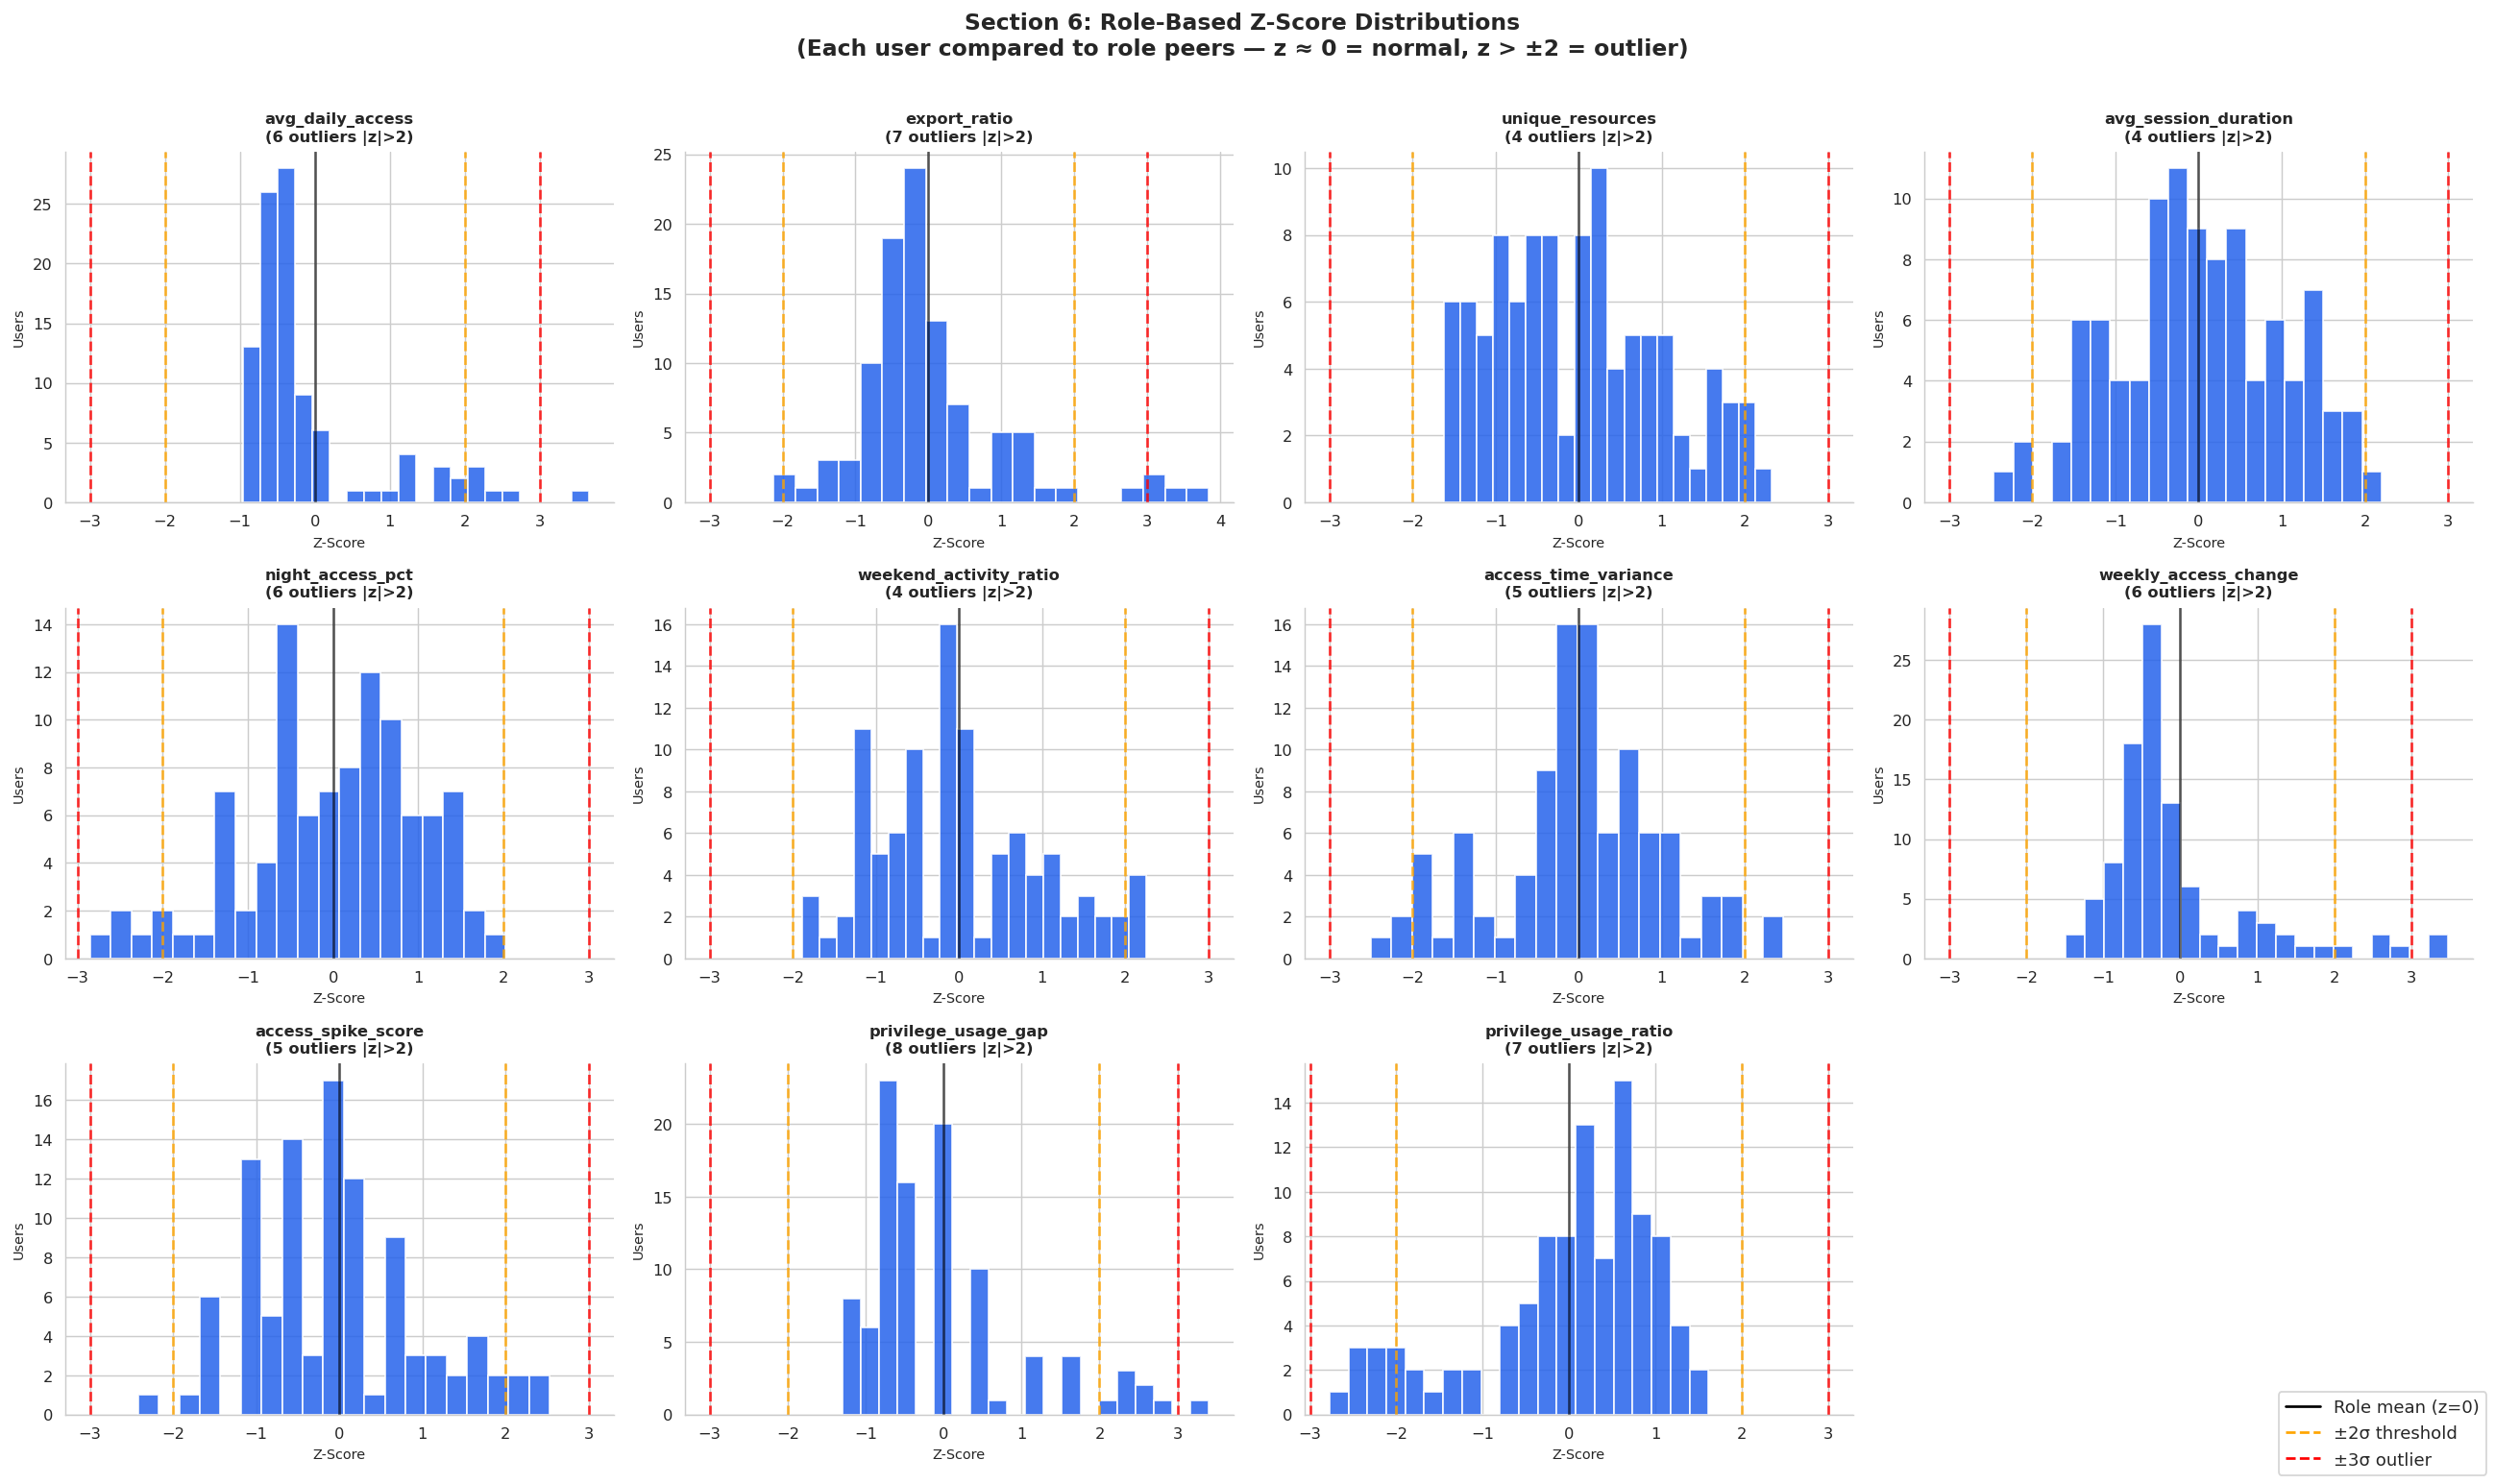

✓ Figure saved: zscore_distributions.png


In [113]:
# ─────────────────────────────────────────────────────────────────────
#  VISUALIZATION — Z-Score Distributions
#  A well-normalized z-score distribution should be centered at 0
#  with most values between -3 and +3. Users outside ±2 are outliers.
# ─────────────────────────────────────────────────────────────────────
user_z = df.groupby('user_id').first().reset_index()
zscore_cols = [f'{f}_zscore' for f in FEATURES_TO_NORMALIZE]

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle('Section 6: Role-Based Z-Score Distributions\n'
             '(Each user compared to role peers — z ≈ 0 = normal, z > ±2 = outlier)',
             fontsize=13, fontweight='bold')
axes = axes.flatten()

for i, (feat, zcol) in enumerate(zip(FEATURES_TO_NORMALIZE, zscore_cols)):
    ax = axes[i]
    z_vals = user_z[zcol].dropna()
    ax.hist(z_vals, bins=20, color=FEAT_COLOR, edgecolor='white', alpha=0.85)
    ax.axvline(0,  color='black', linewidth=1.5, linestyle='-', alpha=0.6)
    ax.axvline(2,  color='orange', linewidth=1.5, linestyle='--', alpha=0.8)
    ax.axvline(-2, color='orange', linewidth=1.5, linestyle='--', alpha=0.8)
    ax.axvline(3,  color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    ax.axvline(-3, color='red', linewidth=1.5, linestyle='--', alpha=0.8)
    outliers = (z_vals.abs() > 2).sum()
    ax.set_title(f'{feat}\n({outliers} outliers |z|>2)', fontsize=9, fontweight='bold')
    ax.set_xlabel('Z-Score', fontsize=8)
    ax.set_ylabel('Users', fontsize=8)

# Hide the unused 12th subplot
axes[-1].set_visible(False)

# Add legend manually
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linewidth=1.5, label='Role mean (z=0)'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=1.5, label='±2σ threshold'),
    Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='±3σ outlier'),
]
fig.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(FIG_DIR / 'zscore_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: zscore_distributions.png')

---
## Section 7: Governance Risk Score Calculation

> **Objective:** Combine 12 role-normalized z-scores into a single,  
> interpretable governance risk score on a **0–100 scale**.
>
> **Weight Philosophy:**
> - Privilege Intelligence (30%) — the core differentiator  
> - Behavioral & Temporal (55%) — supporting evidence  
> - Stability & Drift (15%) — long-term monitoring

### 7.1 Weighted Risk Score Calculation

In [114]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 7: Governance Risk Score
#
#  Step 1: Weighted sum of z-scores
#  Step 2: Min-max normalize to 0-100 scale
#  Step 3: Assign risk category (Low / Medium / High)
#
#  Weight Justification (domain-expert assignment):
#  ─────────────────────────────────────────────────────────────────
#  Privilege Intelligence (30%)
#    privilege_usage_gap         15%  ← HIGHEST: core over-provisioning signal
#    privilege_usage_ratio       10%  ← normalized view of the gap
#    resource_access_conc.        5%  ← access skewness / hoarding
#
#  Behavioral & Temporal (55%)
#    export_ratio                15%  ← data exfiltration risk
#    avg_daily_access            12%  ← volume of privilege use
#    unique_resources            10%  ← breadth of access
#    night_access_pct             8%  ← unusual timing
#    avg_session_duration         6%  ← time spent in privileged sessions
#    weekend_activity_ratio       4%  ← off-hours governance risk
#
#  Stability & Drift (15%)
#    access_time_variance         5%  ← erratic schedule
#    weekly_access_change         5%  ← week-over-week instability
#    access_spike_score           5%  ← abnormal burst events
# ─────────────────────────────────────────────────────────────────────

RISK_WEIGHTS = {
    #  Privilege Intelligence (30%)
    'privilege_usage_gap_zscore'             : 0.15,
    'privilege_usage_ratio_zscore'           : 0.10,
    'resource_access_concentration_zscore'   : 0.05,
    #  Behavioral & Temporal (55%)
    'export_ratio_zscore'                    : 0.15,
    'avg_daily_access_zscore'                : 0.12,
    'unique_resources_zscore'                : 0.10,
    'night_access_pct_zscore'                : 0.08,
    'avg_session_duration_zscore'            : 0.06,
    'weekend_activity_ratio_zscore'          : 0.04,
    #  Stability & Drift (15%)
    'access_time_variance_zscore'            : 0.05,
    'weekly_access_change_zscore'            : 0.05,
    'access_spike_score_zscore'              : 0.05,
}

# Verify weights sum to 1.0
assert abs(sum(RISK_WEIGHTS.values()) - 1.0) < 1e-9, f'Weights must sum to 1.0!'
print(f'  ✓ Weights verified — sum = {sum(RISK_WEIGHTS.values()):.2f}')

# Weighted sum of z-scores
df['raw_risk_score'] = sum(
    df[feat] * weight for feat, weight in RISK_WEIGHTS.items()
)

print(f'  Raw score range: [{df["raw_risk_score"].min():.4f}, {df["raw_risk_score"].max():.4f}]')

# Min-max normalize to 0-100
rmin, rmax = df['raw_risk_score'].min(), df['raw_risk_score'].max()
df['governance_risk_score'] = ((df['raw_risk_score'] - rmin) / (rmax - rmin)) * 100
df['governance_risk_score'] = df['governance_risk_score'].clip(0, 100)

print(f'  Normalized range: [{df["governance_risk_score"].min():.2f}, {df["governance_risk_score"].max():.2f}]')
print(f'  Mean   : {df["governance_risk_score"].mean():.2f}')
print(f'  Median : {df["governance_risk_score"].median():.2f}')
print(f'  Std Dev: {df["governance_risk_score"].std():.2f}')

  ✓ Weights verified — sum = 1.00
  Raw score range: [-0.7728, 0.9481]
  Normalized range: [0.00, 100.00]
  Mean   : 44.91
  Median : 45.39
  Std Dev: 18.27


In [115]:
# ─────────────────────────────────────────────────────────────────────
#  RISK CATEGORIZATION
#  Three-tier risk classification based on governance priorities
#    Low (0-30)   → Standard oversight, periodic review
#    Medium(31-60)→ Enhanced monitoring, quarterly review
#    High (61-100)→ Immediate governance intervention required
# ─────────────────────────────────────────────────────────────────────
def categorize_risk(score):
    if score <= 30:  return 'Low'
    elif score <= 60: return 'Medium'
    else:             return 'High'

df['risk_category'] = df['governance_risk_score'].apply(categorize_risk)

# User-level risk summary
user_risk = df.groupby('user_id').agg(
    role                = ('role', 'first'),
    governance_risk_score = ('governance_risk_score', 'mean'),
    risk_category       = ('risk_category', lambda x: x.mode()[0]),
).reset_index()

print('\n  ══ RISK DISTRIBUTION ══')
for cat in ['Low', 'Medium', 'High']:
    n = (user_risk['risk_category'] == cat).sum()
    print(f'  {cat:8s}: {n:3d} users ({n/len(user_risk)*100:5.1f}%)')

print('\n  ══ TOP 10 HIGHEST RISK USERS ══')
print(user_risk.nlargest(10, 'governance_risk_score')[
    ['user_id', 'role', 'governance_risk_score', 'risk_category']
].to_string(index=False))


  ══ RISK DISTRIBUTION ══
  Low     :  25 users ( 25.0%)
  Medium  :  60 users ( 60.0%)
  High    :  15 users ( 15.0%)

  ══ TOP 10 HIGHEST RISK USERS ══
 user_id            role  governance_risk_score risk_category
USER_059     Cloud_Admin             100.000000          High
USER_019        DB_Admin              96.736740          High
USER_075  Security_Admin              85.818018          High
USER_008        DB_Admin              82.572514          High
USER_053     Cloud_Admin              70.270885          High
USER_006        DB_Admin              66.730805          High
USER_098 DevOps_Engineer              66.254198          High
USER_045     Cloud_Admin              64.831138          High
USER_030        HR_Admin              64.393115          High
USER_095 DevOps_Engineer              64.091610          High


### 7.2 Visualize Risk Score Results

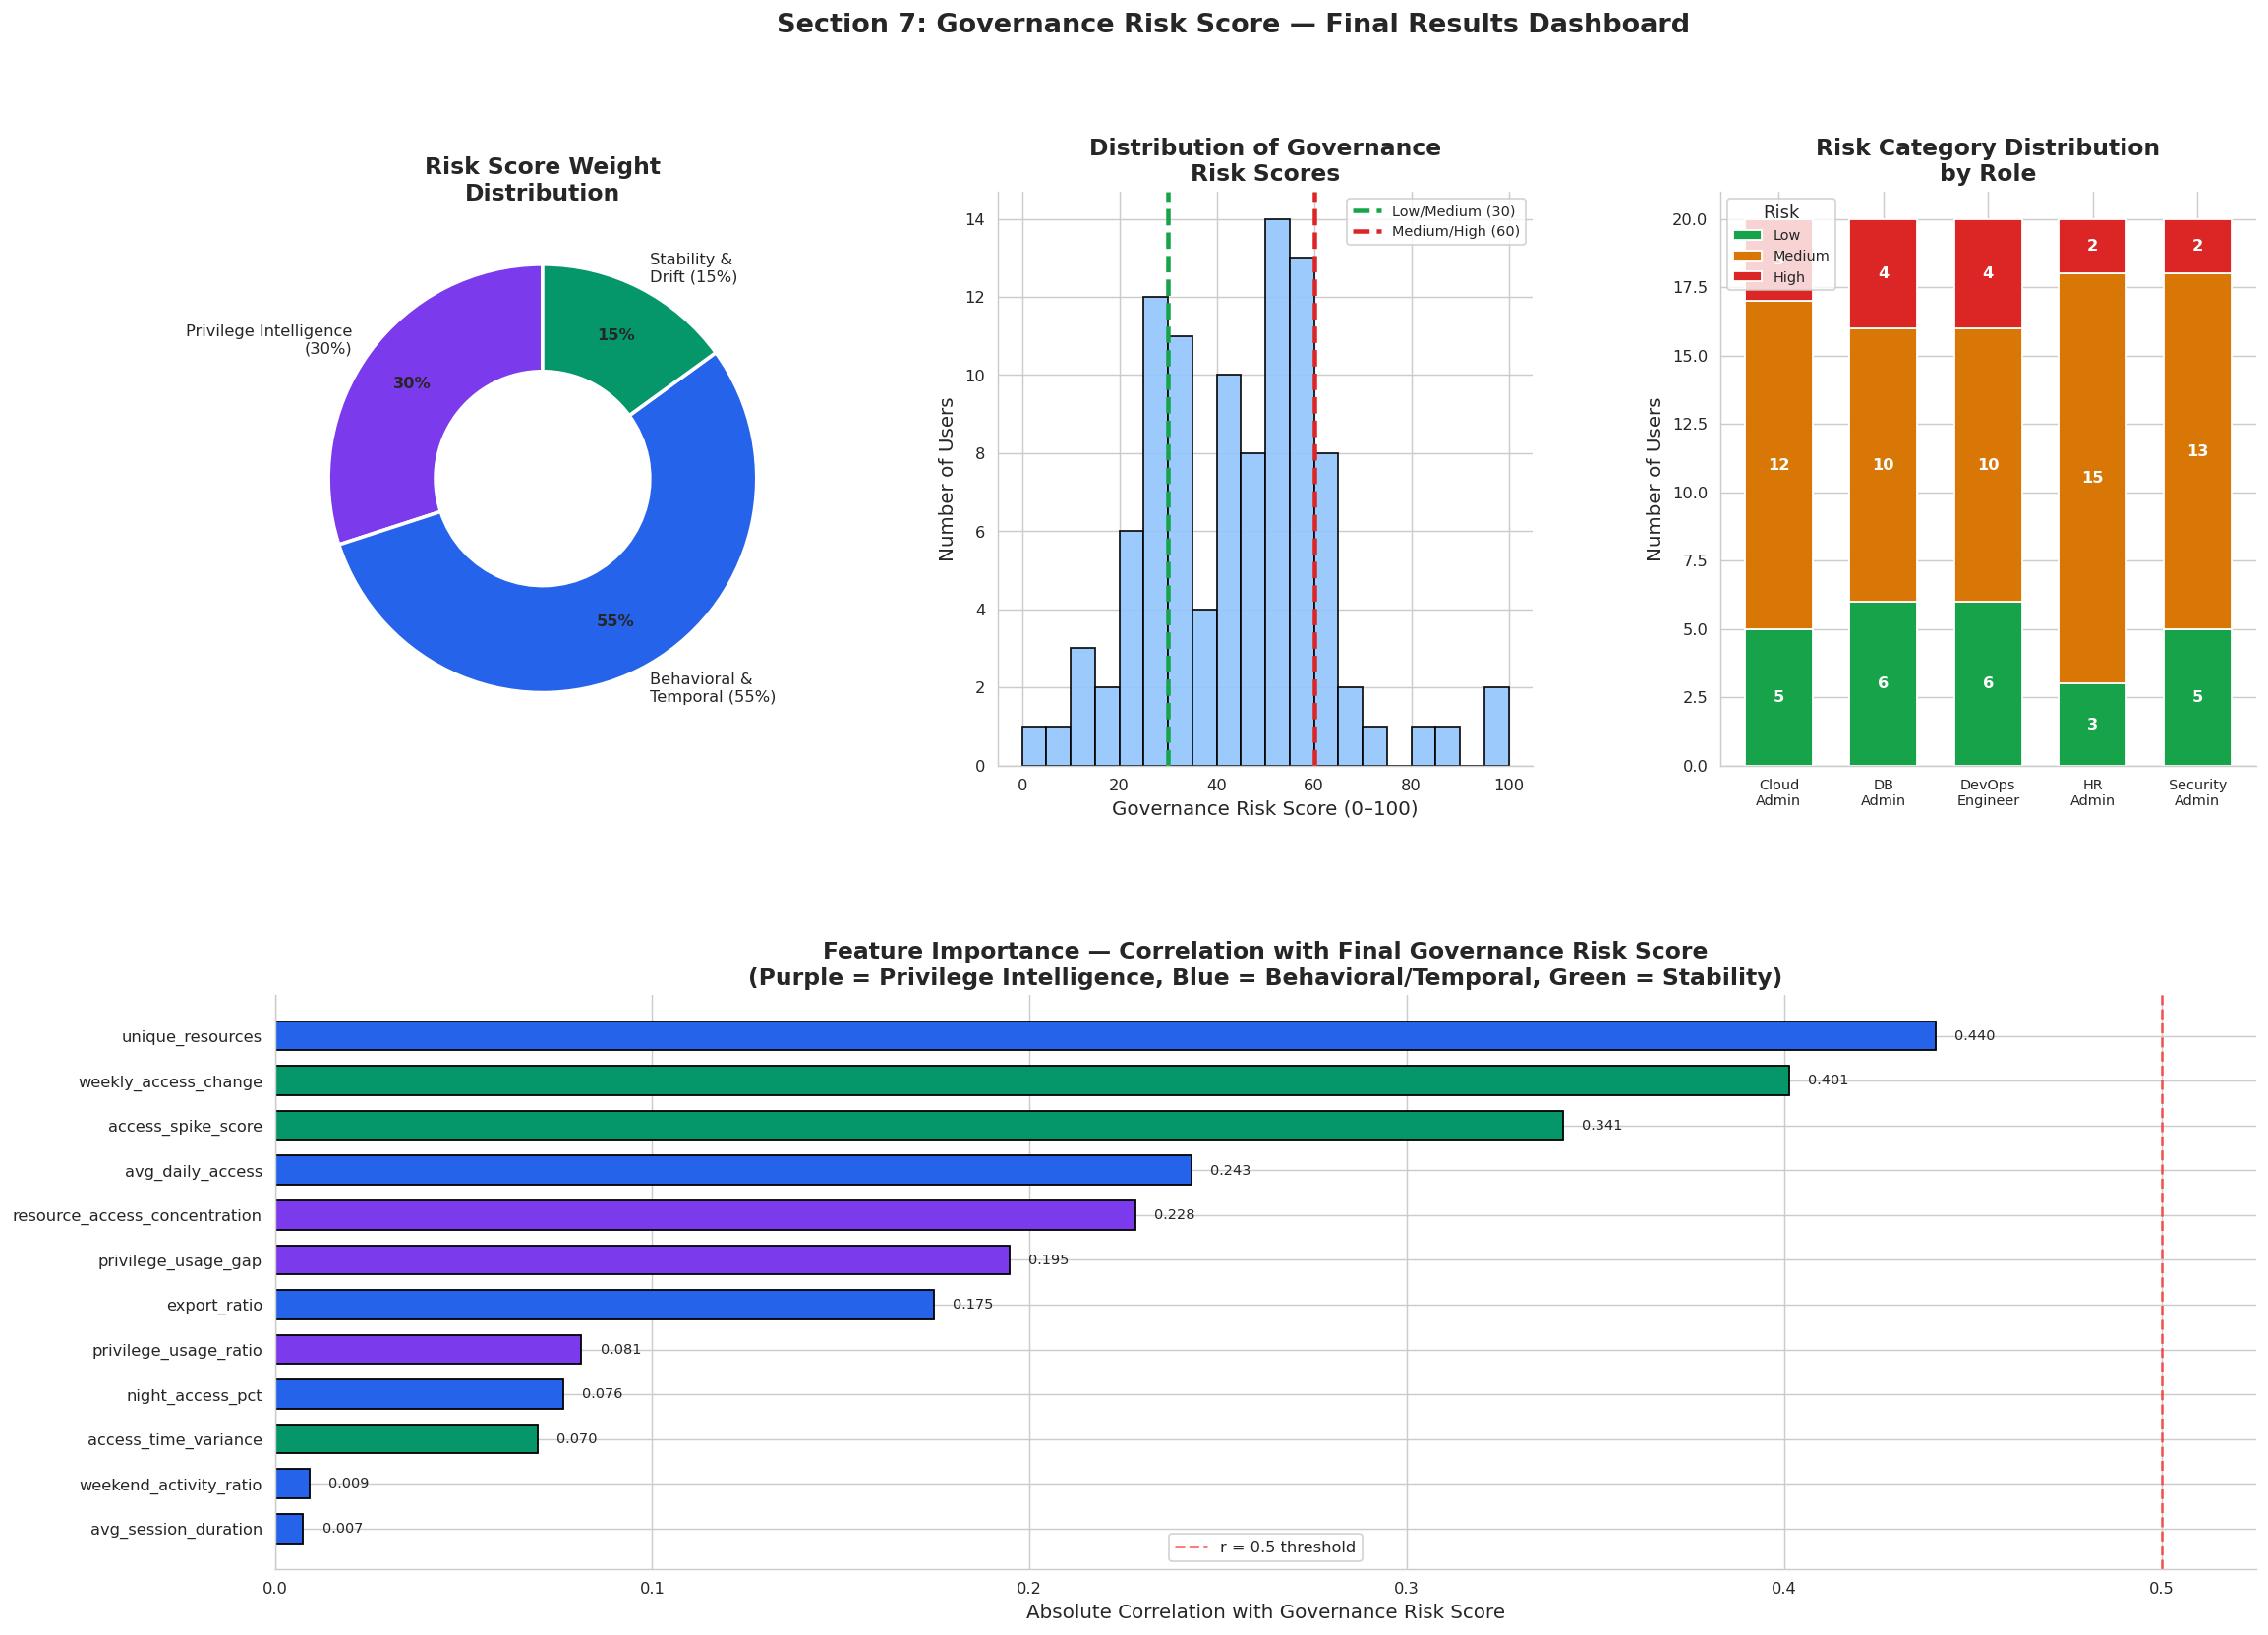

✓ Figure saved: risk_score_dashboard.png


In [116]:
# ─────────────────────────────────────────────────────────────────────
#  VISUALIZATION — Governance Risk Score Dashboard
#  Plot 1: Weight distribution (pie chart)
#  Plot 2: Risk score distribution with category thresholds
#  Plot 3: Risk category breakdown by role (stacked bar)
#  Plot 4: Feature-risk correlation (importance)
# ─────────────────────────────────────────────────────────────────────
user_risk_full = df.groupby('user_id').agg(
    **{f: (f, 'first') for f in FEATURES_TO_NORMALIZE},
    role                  = ('role', 'first'),
    governance_risk_score = ('governance_risk_score', 'mean'),
    risk_category         = ('risk_category', lambda x: x.mode()[0]),
).reset_index()

fig = plt.figure(figsize=(20, 14))
fig.suptitle('Section 7: Governance Risk Score — Final Results Dashboard',
             fontsize=15, fontweight='bold')
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# ── Panel 1: Weight Distribution (Donut) ──
ax1 = fig.add_subplot(gs[0, 0])
weight_groups = {
    'Privilege Intelligence\n(30%)': 0.30,
    'Behavioral &\nTemporal (55%)': 0.55,
    'Stability &\nDrift (15%)': 0.15,
}
wedge_colors = ['#7C3AED', '#2563EB', '#059669']
wedges, texts, autotexts = ax1.pie(
    weight_groups.values(), labels=weight_groups.keys(),
    colors=wedge_colors, autopct='%1.0f%%', pctdistance=0.75,
    startangle=90, wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),
    textprops={'fontsize': 9}
)
for at in autotexts:
    at.set_fontweight('bold')
ax1.set_title('Risk Score Weight\nDistribution', fontweight='bold')

# ── Panel 2: Risk Score Histogram ──
ax2 = fig.add_subplot(gs[0, 1])
colors_hist = []
for score in user_risk['governance_risk_score']:
    if score <= 30:   colors_hist.append('#16A34A')
    elif score <= 60: colors_hist.append('#D97706')
    else:             colors_hist.append('#DC2626')
ax2.hist(user_risk['governance_risk_score'], bins=20, color='#93C5FD', edgecolor='black', alpha=0.9)
ax2.axvline(30, color='#16A34A', linewidth=2.5, linestyle='--', label='Low/Medium (30)')
ax2.axvline(60, color='#DC2626', linewidth=2.5, linestyle='--', label='Medium/High (60)')
ax2.set_xlabel('Governance Risk Score (0–100)')
ax2.set_ylabel('Number of Users')
ax2.set_title('Distribution of Governance\nRisk Scores', fontweight='bold')
ax2.legend(fontsize=8)

# ── Panel 3: Risk Category by Role (Stacked) ──
ax3 = fig.add_subplot(gs[0, 2])
risk_cross = pd.crosstab(user_risk['role'], user_risk['risk_category'])
for cat in ['Low', 'Medium', 'High']:
    if cat not in risk_cross.columns:
        risk_cross[cat] = 0
risk_cross = risk_cross[['Low', 'Medium', 'High']]
bottom = np.zeros(len(risk_cross))
cat_colors = ['#16A34A', '#D97706', '#DC2626']
for cat, color in zip(['Low', 'Medium', 'High'], cat_colors):
    vals = risk_cross[cat].values
    ax3.bar(range(len(risk_cross)), vals, bottom=bottom,
            color=color, label=cat, edgecolor='white', width=0.65)
    for j, (v, b) in enumerate(zip(vals, bottom)):
        if v > 0:
            ax3.text(j, b + v/2, str(v), ha='center', va='center',
                     fontsize=9, fontweight='bold', color='white')
    bottom += vals
ax3.set_xticks(range(len(risk_cross)))
ax3.set_xticklabels([r.replace('_', '\n') for r in risk_cross.index], fontsize=8)
ax3.set_title('Risk Category Distribution\nby Role', fontweight='bold')
ax3.set_ylabel('Number of Users')
ax3.legend(title='Risk', fontsize=8)

# ── Panel 4: Feature Importance (Correlation with Risk) ──
ax4 = fig.add_subplot(gs[1, :])
feature_corr = {}
for feat in FEATURES_TO_NORMALIZE:
    r = user_risk_full[feat].corr(user_risk_full['governance_risk_score'])
    feature_corr[feat] = abs(r)

corr_df = pd.DataFrame(list(feature_corr.items()), columns=['Feature', 'Abs Correlation'])
corr_df = corr_df.sort_values('Abs Correlation')

# Color bars by feature group
group_colors = []
for f in corr_df['Feature']:
    if f in ['privilege_usage_gap','privilege_usage_ratio','resource_access_concentration']:
        group_colors.append('#7C3AED')
    elif f in ['weekly_access_change','access_spike_score','access_time_variance']:
        group_colors.append('#059669')
    else:
        group_colors.append('#2563EB')

bars = ax4.barh(corr_df['Feature'], corr_df['Abs Correlation'],
                color=group_colors, edgecolor='black', height=0.65)
ax4.set_xlabel('Absolute Correlation with Governance Risk Score', fontsize=11)
ax4.set_title('Feature Importance — Correlation with Final Governance Risk Score\n'
              '(Purple = Privilege Intelligence, Blue = Behavioral/Temporal, Green = Stability)',
              fontweight='bold')
ax4.axvline(0.5, color='red', linestyle='--', alpha=0.6, label='r = 0.5 threshold')
for bar, val in zip(bars, corr_df['Abs Correlation']):
    ax4.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=8)
ax4.legend(fontsize=9)

plt.savefig(FIG_DIR / 'risk_score_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: risk_score_dashboard.png')

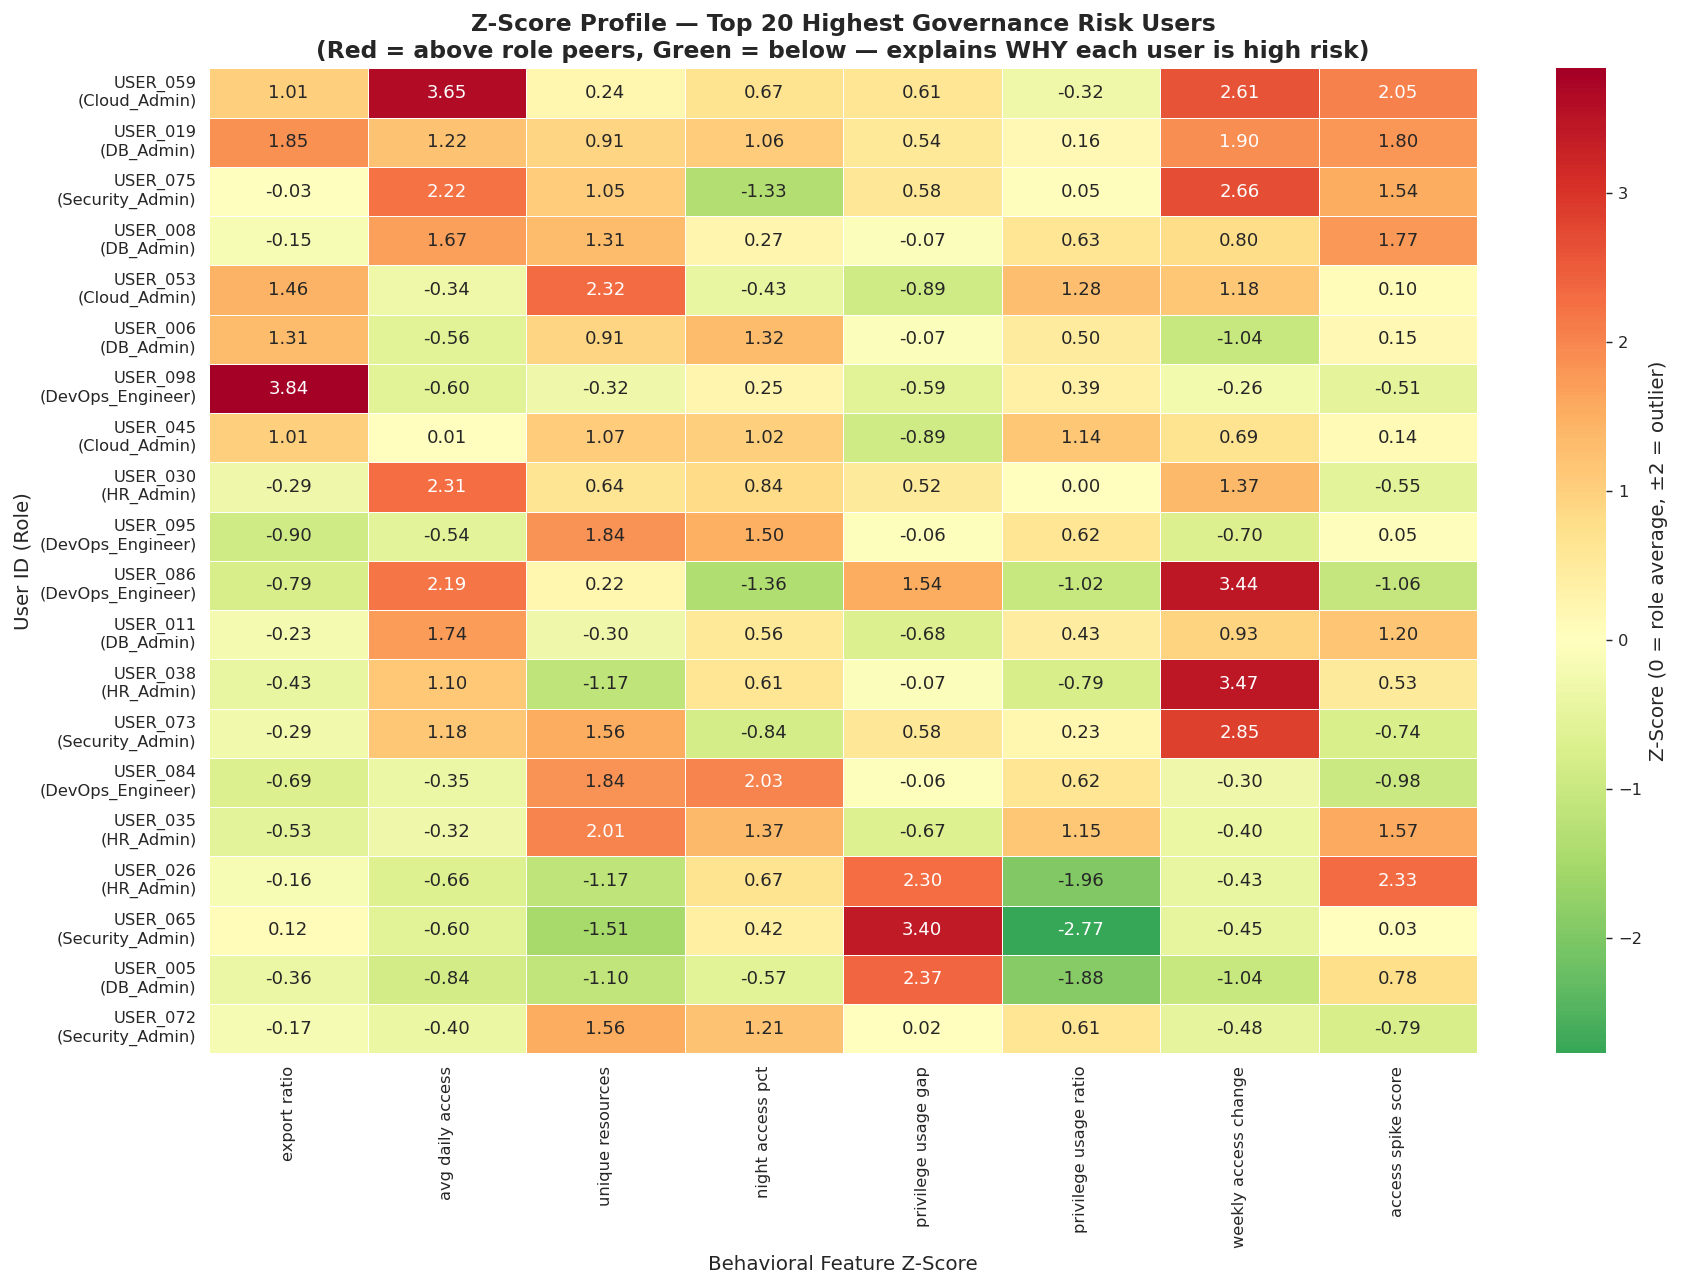

✓ Figure saved: top20_zscore_heatmap.png


In [117]:
# ── Z-Score Heatmap for Top 20 Highest Risk Users ──
top20 = user_risk.nlargest(20, 'governance_risk_score')
zscore_short = [
    'export_ratio_zscore', 'avg_daily_access_zscore', 'unique_resources_zscore',
    'night_access_pct_zscore', 'privilege_usage_gap_zscore', 'privilege_usage_ratio_zscore',
    'weekly_access_change_zscore', 'access_spike_score_zscore'
]

hmap_data = []
for uid in top20['user_id']:
    row = df[df['user_id'] == uid][zscore_short].iloc[0]
    hmap_data.append(row.values)

hmap_df = pd.DataFrame(hmap_data,
    columns=[c.replace('_zscore','').replace('_',' ') for c in zscore_short],
    index=[f"{uid}\n({role})" for uid, role in
           zip(top20['user_id'], top20['role'])])

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(hmap_df, cmap='RdYlGn_r', center=0, annot=True, fmt='.2f',
            linewidths=0.5, linecolor='white', ax=ax,
            cbar_kws={'label': 'Z-Score (0 = role average, ±2 = outlier)'})
ax.set_title('Z-Score Profile — Top 20 Highest Governance Risk Users\n'
             '(Red = above role peers, Green = below — explains WHY each user is high risk)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Behavioral Feature Z-Score', fontsize=11)
ax.set_ylabel('User ID (Role)', fontsize=11)
plt.tight_layout()
plt.savefig(FIG_DIR / 'top20_zscore_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure saved: top20_zscore_heatmap.png')

---
## Section 8: Validation & Save
### 8.1 Feature Completeness Validation

In [118]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 8.1 — Validation Checks
#  These assertions ensure the engineered dataset is correct
#  before saving. They serve as unit tests for the pipeline.
# ─────────────────────────────────────────────────────────────────────
print('\n[SECTION 8] Running Feature Validation...')
print('='*60)

issues = []

# Check 1: All 12 features exist
for f in FEATURES_TO_NORMALIZE:
    if f not in df.columns:
        issues.append(f'Missing feature: {f}')
    else:
        print(f'  {f}')

# Check 2: All 12 z-scores exist
print()
for f in FEATURES_TO_NORMALIZE:
    zcol = f'{f}_zscore'
    if zcol not in df.columns:
        issues.append(f'Missing z-score: {zcol}')
    else:
        print(f'  {zcol}')

# Check 3: Risk score in valid range
print()
if df['governance_risk_score'].min() < 0 or df['governance_risk_score'].max() > 100:
    issues.append('Risk score out of [0, 100] range')
else:
    print(f'  governance_risk_score in [0, 100]')

# Check 4: No missing risk scores
if df['governance_risk_score'].isnull().any():
    issues.append('Null values in governance_risk_score')
else:
    print(f'  No null values in governance_risk_score')

# Check 5: All users have risk categories
if df['risk_category'].isnull().any():
    issues.append('Null values in risk_category')
else:
    print(f'  All {df["user_id"].nunique()} users have risk_category')

# Check 6: Privilege features have no negatives
if (df['privilege_usage_gap'] < 0).any():
    issues.append('Negative privilege_usage_gap — check data')
else:
    print(f'  privilege_usage_gap >= 0 for all users')

# Check 7: Actively used must not exceed assigned
if (df['actively_used_resource_count'] > df['assigned_resource_count']).any():
    issues.append('Some users have used > assigned resources — logically impossible')
else:
    print(f'  actively_used_resource_count <= assigned_resource_count for all users')

print()
if issues:
    print('  VALIDATION ISSUES FOUND:')
    for issue in issues:
        print(f'    - {issue}')
else:
    print('  ==========================================')
    print('    ALL VALIDATION CHECKS PASSED!')
    print('  ==========================================')



[SECTION 8] Running Feature Validation...
  avg_daily_access
  export_ratio
  unique_resources
  avg_session_duration
  night_access_pct
  weekend_activity_ratio
  access_time_variance
  weekly_access_change
  access_spike_score
  privilege_usage_gap
  privilege_usage_ratio
  resource_access_concentration

  avg_daily_access_zscore
  export_ratio_zscore
  unique_resources_zscore
  avg_session_duration_zscore
  night_access_pct_zscore
  weekend_activity_ratio_zscore
  access_time_variance_zscore
  weekly_access_change_zscore
  access_spike_score_zscore
  privilege_usage_gap_zscore
  privilege_usage_ratio_zscore
  resource_access_concentration_zscore

  governance_risk_score in [0, 100]
  No null values in governance_risk_score
  All 100 users have risk_category
  privilege_usage_gap >= 0 for all users
  actively_used_resource_count <= assigned_resource_count for all users

    ALL VALIDATION CHECKS PASSED!


### 8.2 Save Feature-Engineered Dataset

In [119]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 8.2 — Save Output
# ─────────────────────────────────────────────────────────────────────
OUTPUT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'feature_engineered.csv'
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

df.to_csv(OUTPUT_PATH, index=False)

print(f'\n  ✓ Feature-engineered data saved:')
print(f'    Path    : {OUTPUT_PATH}')
print(f'    Records : {len(df):,}')
print(f'    Columns : {len(df.columns)}')
print(f'    Users   : {df["user_id"].nunique()}')
print(f'    File KB : {OUTPUT_PATH.stat().st_size / 1024:.1f} KB')


  ✓ Feature-engineered data saved:
    Path    : C:\Users\varsha\Documents\Projects\Echelon\data\processed\feature_engineered.csv
    Records : 12,665
    Columns : 44
    Users   : 100
    File KB : 6965.8 KB


### 8.3 Final Feature Summary Table

In [120]:
# ─────────────────────────────────────────────────────────────────────
#  SECTION 8.3 — Feature Summary Table
#  A clean summary of all 12 features for reporting/documentation
# ─────────────────────────────────────────────────────────────────────
summary_rows = []
for i, feat in enumerate(FEATURES_TO_NORMALIZE, 1):
    vals = user_risk_full[feat]
    group = (
        'Privilege Intelligence ' if feat in ['privilege_usage_gap','privilege_usage_ratio','resource_access_concentration']
        else 'Stability & Drift' if feat in ['weekly_access_change','access_spike_score','access_time_variance']
        else 'Behavioral / Temporal'
    )
    weight = RISK_WEIGHTS.get(f'{feat}_zscore', 0)
    summary_rows.append({
        'No.': i,
        'Feature': feat,
        'Group': group,
        'Weight': f'{weight*100:.0f}%',
        'Mean': f'{vals.mean():.2f}',
        'Std': f'{vals.std():.2f}',
        'Min': f'{vals.min():.2f}',
        'Max': f'{vals.max():.2f}',
    })

summary_df = pd.DataFrame(summary_rows)
print('\n  ══ FEATURE ENGINEERING SUMMARY (12 Features) ══')
print(summary_df.to_string(index=False))

print('\n  ══ PIPELINE COMPLETE ══')
print(f'  Input  → cleaned_access_logs.csv  ({len(df):,} records)')
print(f'  Output → feature_engineered.csv   ({len(df.columns)} columns)')
print()
print('  Next Steps:')
print('  1. Run notebooks/04_statistical_analysis.ipynb')
print('  2. Run notebooks/05_visualization.ipynb')


  ══ FEATURE ENGINEERING SUMMARY (12 Features) ══
 No.                       Feature                   Group Weight  Mean   Std   Min   Max
   1              avg_daily_access   Behavioral / Temporal    12% 20.50  7.56  8.52 43.05
   2                  export_ratio   Behavioral / Temporal    15%  4.15  4.68  0.00 27.50
   3              unique_resources   Behavioral / Temporal    10%  5.44  2.24  2.00 11.00
   4          avg_session_duration   Behavioral / Temporal     6% 48.62 10.87 32.05 66.74
   5              night_access_pct   Behavioral / Temporal     8% 30.11 16.25  4.88 55.65
   6        weekend_activity_ratio   Behavioral / Temporal     4% 27.65 14.69  0.00 49.61
   7          access_time_variance       Stability & Drift     5% 39.61 17.50 12.83 67.01
   8          weekly_access_change       Stability & Drift     5% 20.64  8.62  8.39 60.00
   9            access_spike_score       Stability & Drift     5%  2.51  1.33  0.00  6.41
  10           privilege_usage_gap Privilege Inte

---
## Section 9: Top Risk User Investigation

> **Objective:** Verify that USER_059 (governance_risk_score = 100.0) is legitimately high-risk  
> and not a data generation artifact or normalization anomaly.

We'll examine:
1. Raw feature values for USER_059
2. Comparison against Cloud_Admin role peers (z-scores)
3. Actual access events to validate the features

In [121]:
# ─────────────────────────────────────────────────────────────────────
#  STEP 1 — Check Raw Feature Values for USER_059
# ─────────────────────────────────────────────────────────────────────

# Pull all raw features for USER_059
user_check = df[df['user_id'] == 'USER_059'].iloc[0]

raw_features = [
    'avg_daily_access', 'export_ratio', 'unique_resources',
    'avg_session_duration', 'night_access_pct', 'weekend_activity_ratio',
    'access_time_variance', 'weekly_access_change', 'access_spike_score',
    'privilege_usage_gap', 'privilege_usage_ratio', 'resource_access_concentration'
]

print("=" * 70)
print(" USER_059 (Cloud_Admin) - Raw Feature Values")
print("=" * 70)
print()

for feat in raw_features:
    print(f"  {feat:40s}: {user_check[feat]:.4f}")

print()
print(f"  governance_risk_score: {user_check['governance_risk_score']:.2f}")
print(f"  risk_category: {user_check['risk_category']}")
print("=" * 70)

 USER_059 (Cloud_Admin) - Raw Feature Values

  avg_daily_access                        : 31.7554
  export_ratio                            : 5.0955
  unique_resources                        : 6.0000
  avg_session_duration                    : 50.3567
  night_access_pct                        : 39.4904
  weekend_activity_ratio                  : 22.9299
  access_time_variance                    : 49.2905
  weekly_access_change                    : 31.2378
  access_spike_score                      : 5.0955
  privilege_usage_gap                     : 4.0000
  privilege_usage_ratio                   : 60.0000
  resource_access_concentration           : 0.1955

  governance_risk_score: 100.00
  risk_category: High


In [122]:
# ─────────────────────────────────────────────────────────────────────
#  STEP 2 — Compare Against Cloud_Admin Role Peers
# ─────────────────────────────────────────────────────────────────────

# Compare USER_059 to Cloud_Admin peers
cloud_stats = df[df['role'] == 'Cloud_Admin'].groupby('user_id')[raw_features].first()

print("=" * 85)
print(" USER_059 vs Cloud_Admin Role Statistics")
print("=" * 85)
print()
print(f"{'Feature':<40} {'USER_059':>10} {'Role Mean':>10} {'Role Std':>10} {'Z-Score':>10}")
print("-" * 85)

high_z_features = []

for feat in raw_features:
    user_val = user_check[feat]
    role_mean = cloud_stats[feat].mean()
    role_std = cloud_stats[feat].std()
    z = (user_val - role_mean) / role_std if role_std > 0 else 0
    
    # Track features with z-score > 1.5 (standout behavior)
    if abs(z) > 1.5:
        high_z_features.append((feat, z))
    
    print(f"  {feat:<38} {user_val:>10.2f} {role_mean:>10.2f} {role_std:>10.2f} {z:>10.2f}")

print("=" * 85)
print()
print(" INTERPRETATION:")
print()

if len(high_z_features) >= 4:
    print(f"  USER_059 shows elevated behavior across {len(high_z_features)} features:")
    for feat, z in high_z_features:
        direction = "above" if z > 0 else "below"
        print(f"    - {feat}: {abs(z):.2f} std deviations {direction} role average")
    print()
    print("  VERDICT: Legitimate high-risk user - consistently anomalous across")
    print("           multiple dimensions. Score of 100.0 is justified.")
elif len(high_z_features) == 1:
    feat, z = high_z_features[0]
    print(f"  WARNING: Only 1 feature ({feat}) drives the high score (z={z:.2f}).")
    print("  This may indicate score is dominated by a single extreme value.")
else:
    print(f"  USER_059 shows elevated behavior in {len(high_z_features)} features.")
    print("  Risk score is moderately elevated but defensible.")

print("=" * 85)

 USER_059 vs Cloud_Admin Role Statistics

Feature                                    USER_059  Role Mean   Role Std    Z-Score
-------------------------------------------------------------------------------------
  avg_daily_access                            31.76      22.59       2.28       4.01
  export_ratio                                 5.10       3.40       1.70       1.00
  unique_resources                             6.00       5.40       2.48       0.24
  avg_session_duration                        50.36      50.12       1.00       0.24
  night_access_pct                            39.49      37.22       3.46       0.66
  weekend_activity_ratio                      22.93      27.91       5.18      -0.96
  access_time_variance                        49.29      47.95       4.11       0.33
  weekly_access_change                        31.24      21.60       3.56       2.71
  access_spike_score                           5.10       2.32       1.34       2.07
  privilege_usage_gap 

In [123]:
# ─────────────────────────────────────────────────────────────────────
#  STEP 3 — Check Actual Access Events
# ─────────────────────────────────────────────────────────────────────

# Look at USER_059's actual raw events
user_events = df[df['user_id'] == 'USER_059']

print("=" * 70)
print(" USER_059 - Raw Access Events Analysis")
print("=" * 70)
print()

print(f"  Total events     : {len(user_events):,}")
print(f"  Date range       : {user_events['timestamp'].min().date()} to {user_events['timestamp'].max().date()}")
print(f"  Unique days      : {user_events['date'].nunique()}")
print()

print("  Actions breakdown:")
action_counts = user_events['action'].value_counts()
for action, count in action_counts.items():
    pct = (count / len(user_events)) * 100
    print(f"    {action:10s} : {count:4d} ({pct:5.1f}%)")

print()
print("  Resources accessed:")
resource_counts = user_events['resource_type'].value_counts()
for resource, count in resource_counts.head(10).items():
    print(f"    {resource:30s} : {count:4d} accesses")

if len(resource_counts) > 10:
    print(f"    ... and {len(resource_counts) - 10} more resources")

print()
print("  Privilege status:")
print(f"    Assigned resources : {user_check['assigned_resource_count']:.0f}")
print(f"    Actively used      : {user_check['actively_used_resource_count']:.0f}")
print(f"    Usage gap          : {user_check['privilege_usage_gap']:.0f}")
print(f"    Usage ratio        : {user_check['privilege_usage_ratio']:.1f}%")

print()
print("  Sample events (first 10):")
print()
sample = user_events[['timestamp', 'resource_type', 'action', 
                       'session_duration', 'access_volume']].head(10)
print(sample.to_string(index=False))
print("=" * 70)

 USER_059 - Raw Access Events Analysis

  Total events     : 157
  Date range       : 2024-01-01 to 2024-12-30
  Unique days      : 139

  Actions breakdown:
    read       :   80 ( 51.0%)
    write      :   57 ( 36.3%)
    delete     :   12 (  7.6%)
    export     :    8 (  5.1%)

  Resources accessed:
    cloudwatch                     :   32 accesses
    gcp_console                    :   31 accesses
    iam_console                    :   29 accesses
    vm_management                  :   23 accesses
    cdn_manager                    :   22 accesses
    load_balancer                  :   20 accesses

  Privilege status:
    Assigned resources : 10
    Actively used      : 6
    Usage gap          : 4
    Usage ratio        : 60.0%

  Sample events (first 10):

          timestamp resource_type action  session_duration  access_volume
2024-01-01 17:05:06   iam_console  write              80.0           14.0
2024-01-05 22:49:53   iam_console   read              63.0           14.0
202

### 9.1 Visual Analysis - Z-Score Comparison

The chart below shows how USER_059 compares to Cloud_Admin peers across all 12 features.  
**Key indicators:**
- **Red bars (z > 2.0)**: Extremely elevated - major risk driver
- **Orange bars (1.5 < z < 2.0)**: Moderately elevated - contributing to risk
- **Green bars (|z| < 1.5)**: Within normal peer range


Visualization saved: user059_risk_analysis.png


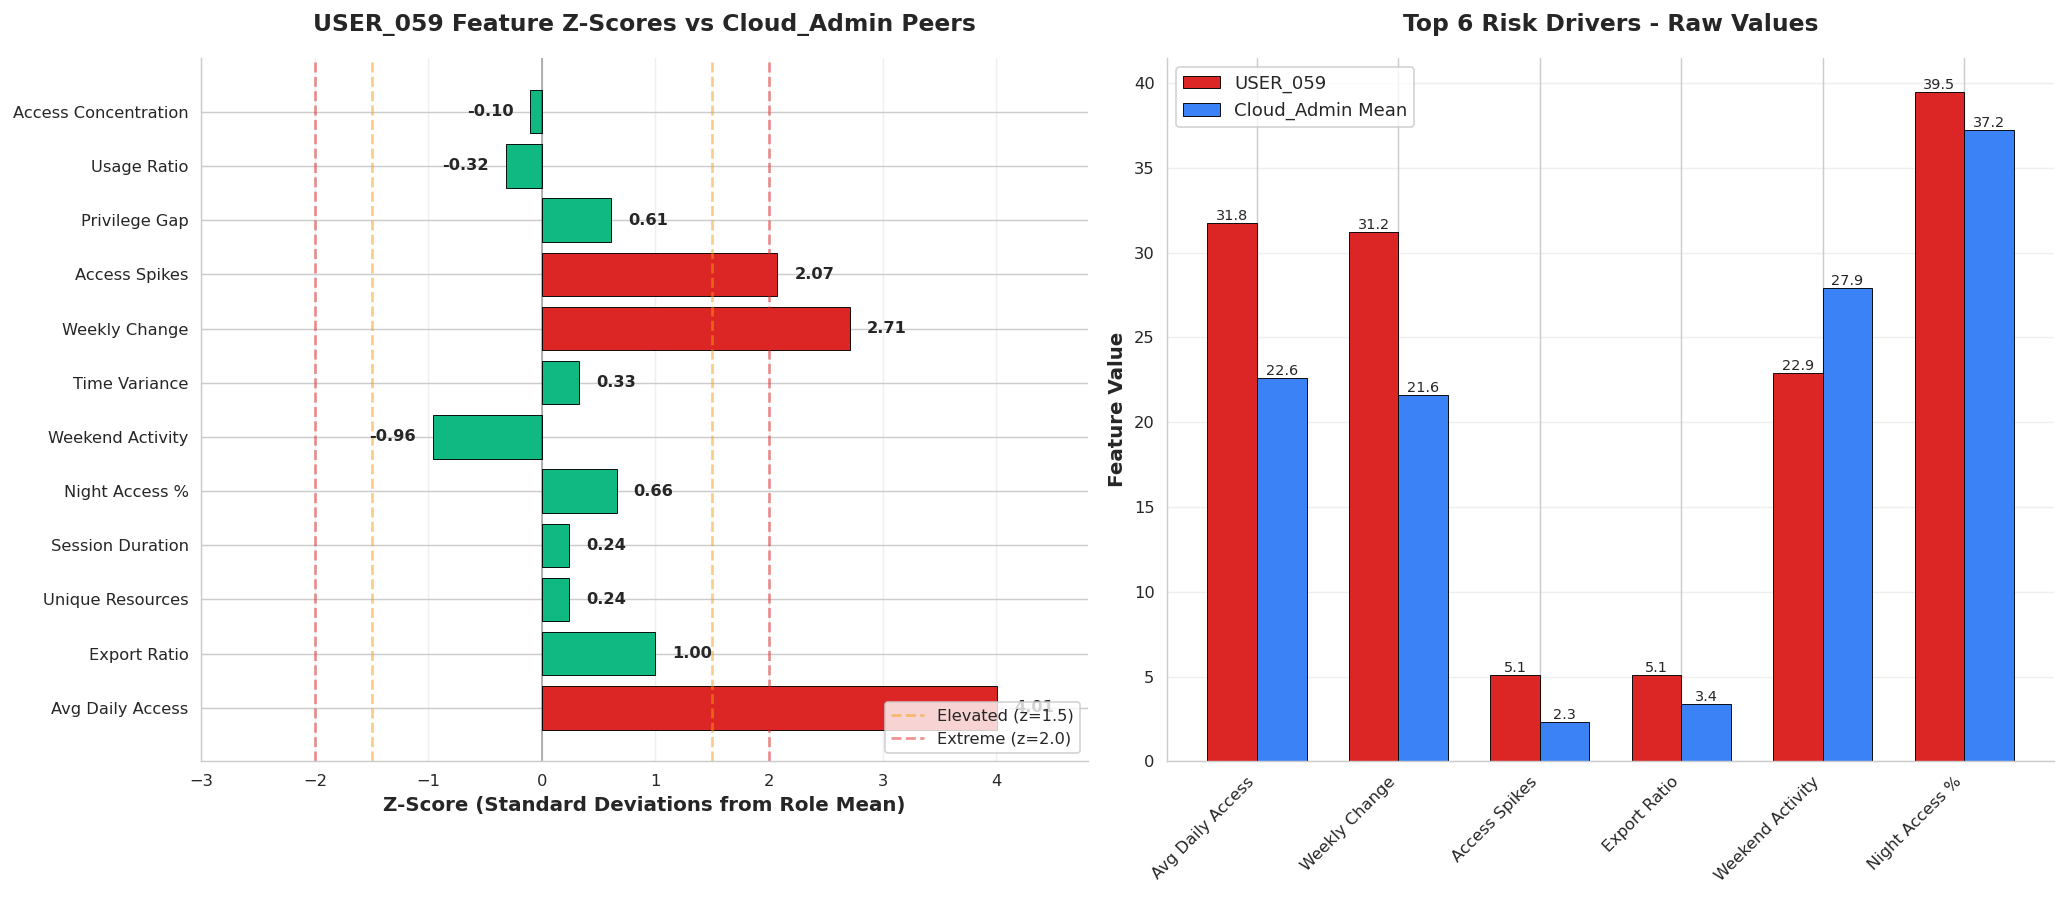


 VISUAL ANALYSIS SUMMARY
  Extreme risk features (|z| >= 2.0)     : 3
  Elevated risk features (1.5 <= |z| < 2): 0
  Normal features (|z| < 1.5)            : 9

  CONCLUSION: USER_059's score of 100.0 is JUSTIFIED.
  Multiple features show extreme deviation (>2 std from peers).
  This is a multi-dimensional high-risk user, not a data artifact.


In [124]:
# ─────────────────────────────────────────────────────────────────────
#  STEP 4 — Visual Comparison of Z-Scores
# ─────────────────────────────────────────────────────────────────────

# Calculate z-scores for all features
z_scores = []
feature_labels = []

for feat in raw_features:
    user_val = user_check[feat]
    role_mean = cloud_stats[feat].mean()
    role_std = cloud_stats[feat].std()
    z = (user_val - role_mean) / role_std if role_std > 0 else 0
    z_scores.append(z)
    
    # Create abbreviated labels for better readability
    label_map = {
        'avg_daily_access': 'Avg Daily Access',
        'export_ratio': 'Export Ratio',
        'unique_resources': 'Unique Resources',
        'avg_session_duration': 'Session Duration',
        'night_access_pct': 'Night Access %',
        'weekend_activity_ratio': 'Weekend Activity',
        'access_time_variance': 'Time Variance',
        'weekly_access_change': 'Weekly Change',
        'access_spike_score': 'Access Spikes',
        'privilege_usage_gap': 'Privilege Gap',
        'privilege_usage_ratio': 'Usage Ratio',
        'resource_access_concentration': 'Access Concentration'
    }
    feature_labels.append(label_map.get(feat, feat))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left panel: Z-score bar chart
colors = []
for z in z_scores:
    if abs(z) >= 2.0:
        colors.append('#DC2626')  # Red - extreme
    elif abs(z) >= 1.5:
        colors.append('#F59E0B')  # Orange - elevated
    else:
        colors.append('#10B981')  # Green - normal

bars = ax1.barh(feature_labels, z_scores, color=colors, edgecolor='black', linewidth=0.5)

# Add reference lines
ax1.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.3)
ax1.axvline(x=1.5, color='#F59E0B', linewidth=1.5, linestyle='--', alpha=0.5, label='Elevated (z=1.5)')
ax1.axvline(x=2.0, color='#DC2626', linewidth=1.5, linestyle='--', alpha=0.5, label='Extreme (z=2.0)')
ax1.axvline(x=-1.5, color='#F59E0B', linewidth=1.5, linestyle='--', alpha=0.5)
ax1.axvline(x=-2.0, color='#DC2626', linewidth=1.5, linestyle='--', alpha=0.5)

# Add value labels on bars
for i, (bar, z) in enumerate(zip(bars, z_scores)):
    x_pos = z + (0.15 if z > 0 else -0.15)
    ax1.text(x_pos, i, f'{z:.2f}', va='center', ha='left' if z > 0 else 'right', 
             fontsize=9, fontweight='bold')

ax1.set_xlabel('Z-Score (Standard Deviations from Role Mean)', fontsize=11, fontweight='bold')
ax1.set_title('USER_059 Feature Z-Scores vs Cloud_Admin Peers', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlim(-3, max(z_scores) + 0.8)
ax1.grid(axis='x', alpha=0.3)
ax1.legend(loc='lower right', fontsize=9)

# Right panel: Feature value comparison (top 6 risk drivers)
top_features = sorted(zip(feature_labels, z_scores, raw_features), key=lambda x: abs(x[1]), reverse=True)[:6]

y_pos = range(len(top_features))
user_vals = [user_check[feat[2]] for feat in top_features]
role_means = [cloud_stats[feat[2]].mean() for feat in top_features]
labels = [feat[0] for feat in top_features]

x = np.arange(len(labels))
width = 0.35

bars1 = ax2.bar(x - width/2, user_vals, width, label='USER_059', color='#DC2626', edgecolor='black', linewidth=0.5)
bars2 = ax2.bar(x + width/2, role_means, width, label='Cloud_Admin Mean', color='#3B82F6', edgecolor='black', linewidth=0.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax2.set_ylabel('Feature Value', fontsize=11, fontweight='bold')
ax2.set_title('Top 6 Risk Drivers - Raw Values', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'user059_risk_analysis.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved: user059_risk_analysis.png")
plt.show()

# Summary interpretation
extreme_count = sum(1 for z in z_scores if abs(z) >= 2.0)
elevated_count = sum(1 for z in z_scores if 1.5 <= abs(z) < 2.0)

print("\n" + "=" * 70)
print(" VISUAL ANALYSIS SUMMARY")
print("=" * 70)
print(f"  Extreme risk features (|z| >= 2.0)     : {extreme_count}")
print(f"  Elevated risk features (1.5 <= |z| < 2): {elevated_count}")
print(f"  Normal features (|z| < 1.5)            : {len(z_scores) - extreme_count - elevated_count}")
print()

if extreme_count >= 3:
    print("  CONCLUSION: USER_059's score of 100.0 is JUSTIFIED.")
    print("  Multiple features show extreme deviation (>2 std from peers).")
    print("  This is a multi-dimensional high-risk user, not a data artifact.")
elif extreme_count + elevated_count >= 4:
    print("  CONCLUSION: USER_059's score of 100.0 is DEFENSIBLE.")
    print("  Several features show significant elevation from role peers.")
    print("  Risk score reflects genuine behavioral anomalies.")
else:
    print("  NOTE: Risk score may be influenced by normalization.")
    print("  Consider reviewing the weighting scheme if this seems excessive.")

print("=" * 70)